# I - Initialisation
## 1 - Setup components
### A) Import librairies

In [2]:
# !pip install -q -U keras-tuner
# !pip install -q -U tensorflow
# !pip install -q -U pandas
# !pip install -U scikit-learn
# !pip install -q -U matplotlib
# !pip install -q -U openpyxl

# Basic librairies
import pandas as pd
import numpy as np
from random import randint
from math import floor, isinf
import time
import datetime
import pickle
import warnings
import os
from os import mkdir
from sklearn.exceptions import ConvergenceWarning

# Math librairies
import sklearn # for model evaluation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ttest_ind, chi2
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split  # for splitting data into train and test samples
from sklearn.metrics import confusion_matrix, accuracy_score
from lazypredict.Supervised import LazyClassifier

#Hyperparameter Tuning sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection

from tensorflow import keras  # for building Neural Networks
import keras_tuner as kt
import tensorflow as tf
from keras.models import Model, load_model # for creating a linear stack of layers for our Neural Network
from tensorflow.keras.layers import Dense, Input, GaussianNoise, Dropout # for creating regular densely-connected NN layers.
from tensorflow.keras.models import Model # for creating a linear stack of layers for our Neural Network
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import HeNormal, Constant

# Graphs librairies
import matplotlib.pyplot as plt
from matplotlib import ticker


# Allow interactive graphs in notebooks for Jetbrains PyCharm
# Comment this line to display graphs in Google Colaboratory
#%matplotlib notebook

path = 'data/'

Uncomment to use on Google Colaboratory

In [3]:
# from google.colab import drive
#
# print("Importing my Google Drive")
# drive.mount('/content/drive')
#
# print("Google Drive imported")
# path = '/content/drive/MyDrive/Neurocovid-project/Thibault/'

### 2 - Project functions

In [4]:
def clean_list_string(var):
	if type(var) is str and var.lower() not in ('no', 'non', 'none'):
		var = var.lower()
		"""
		par_start, par_end = var.find('('), var.find(')')
		if par_start != -1 and par_end != -1:
			var = var[:par_start] + var[par_end+1:]
		"""
		for to_remove, replacement in (('covalescent', 'convalescent'), ('dexmethasone', 'dexamethasone'), ('remdesivier', 'remdesivir'),
									   ('tocilizamab', 'tocilizumab'), ('i-spy', 'i spy'),
									   ('disease', ''),
									   ('rescreen', ''), ('not screened', ''), ('screen', ''), ('zsfg', ''),
									   (u'\xa0', ' '), ('.', ''), ('and', ''), ('vs placebo', ''), ('iv ', ' '), ('pre-', 'pre '), ('-', ', '), ('\n', ' '), ('also ', ''),
									   (', as well as', '1 as well as'), ('Neuropathology on Autopsy: ', '')):
			var = var.replace(to_remove, replacement)
		while var.find('  ') != -1:
			var = var.replace('  ', ' ')
		var = var.strip()

		if len(var) > 0:
			if var[-1] == ',': var = var[:-1]
			return var
		else:
			return None
	else:
		return None


def get_categories_from_lists(df, column):
	dimensions = set()

	for val in df[column].unique():
		if type(val) is str:
			for symptom in val.split(', '):
				if len(symptom) > 0:
					dimensions.add(symptom)
		#else: print("Eliminating category [", val, "]", sep='')
	#print(len(dimensions), "categories found:", sorted(dimensions), '\n')

	return dimensions


def get_dummies_from_lists(df, column, prefix='', suffix=''):

	dimensions = get_categories_from_lists(df, column)

	for dimension in dimensions:
		df[prefix + dimension + suffix] = df[column].apply(lambda var: False if var is None or type(var) == float or var.find(dimension) == -1 else True)

	del df[column]

	return dimensions


def analyse_dataframe(df):
	print(len(df.columns), "columns\n", len(df), "rows\n")

	n= len(df)
	cols = pd.DataFrame(columns=('type', 'number of different values', 'NaN values', 'True values'))

	for i in df.columns:
		val_counts = df[i].value_counts()  # Counts the number of values

		if df.dtypes[i] is str or df.dtypes[i] == 'object':
			print()  # Add spaces before a categorical values column

		if df.dtypes[i] == 'bool':
			cols.loc[i] = [df.dtypes[i], '', '', str(round(100*df[i].sum()/n, 1)) + "%"]
		else:
			cols.loc[i] = [df.dtypes[i], len(val_counts), str(round(100*df[i].isnull().sum()/n, 1)) + "%", '']

		if df.dtypes[i] is str or df.dtypes[i] == 'object':
			print(i, " (", len(val_counts), " values):\n", val_counts, "\n", sep='')  # List categories of a categorical column

	return cols


# Data standardisation, dropping unnecessary columns
def preprocess_data(df, scale_path=None, scaler='Standard'):

    # scale
    if scaler == 'Standard': scaler=StandardScaler()
    else: scaler = MinMaxScaler()
    scaled_cont_data=scaler.fit_transform(df)

    #save scaler for scaling of new data
    if scale_path is not None:
        pickle.dump(scaler, open(scale_path + '.pyc','wb'))

    # put in new dataframe
    return pd.DataFrame(scaled_cont_data, columns=df.columns)


# Overwrite run trial to tune batch size and to apply cross validation
class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, x, y, epochs, callbacks=None, *args, **kwargs):

        cv = model_selection.KFold(5)
        val_losses = []
        for train_indices, test_indices in cv.split(x):
            x_test, y_test = x.iloc[test_indices], y.iloc[test_indices]

            model = self.hypermodel.build(trial.hyperparameters)
            print(x.iloc[train_indices].shape, y.iloc[train_indices].shape, type((x_test, y_test)), type(batch_size), type(epochs), type(callbacks))

            model.fit(x.iloc[train_indices], y.iloc[train_indices], validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=callbacks)
            model.fit(x.iloc[train_indices], y.iloc[train_indices], validation_data=(x_test, y_test),
                      batch_size=batch_size, epochs=epochs, callbacks=callbacks)

            val_losses.append(model.evaluate(x_test, y_test, return_dict=True)['loss'])

        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
        #self.save_model(trial.trial_id, model)


# model construction for training
def build_model(input_shape, num_layers=3, units=[20,20,20,20,20,20,20], learning_rate=0.01, activation='relu',
                dropout=False, droprates=[0.2,0.2,0.2,0.2,0.2,0.2,0.2], noise_dev=None):

    initializer=HeNormal()
    bias_initializer=Constant(0.2)

    model = Sequential()

    # Data augmentation layer if wanted
    if noise_dev is not None:
      model.add(GaussianNoise(stddev=noise_dev,input_dim=input_shape))
      model.add(Dense(units[0], activation=activation, kernel_initializer=initializer, bias_initializer=bias_initializer))
    else:
      model.add(Dense(units[0], activation=activation, input_dim=input_shape, kernel_initializer=initializer, bias_initializer=bias_initializer))

    # Add layers in for loop to be able to tune number of layers
    for i in range(1, num_layers):
      model.add(Dense(units[i], activation=activation, kernel_initializer=initializer, bias_initializer=bias_initializer))
      if dropout and len(droprates) > i:
        model.add(Dropout(droprates[i]))

    model.add(Dense(1,  activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
def build_tuning_model(hp, input_shape, n_layers=(1, 4), n_units=(8, 64), activation=('relu','elu'), learning_rate=(.0001, .1), noise=None):

    # Initializer
    initializer=HeNormal()
    bias_initializer=Constant(0.2)

    # Set Hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=learning_rate[0], max_value=learning_rate[1], sampling='log')
    activation = activation if type(activation) == str else hp.Choice('activation', activation)
    num_layers = hp.Int('num_layers', min_value=n_layers[0], max_value=n_layers[1], step=1)

    model = Sequential()

    # Data augmentation layer if wanted
    if noise is not None:
        model.add(GaussianNoise(stddev=hp.Float('stddev', min_value=noise[0], max_value=noise[1]),input_dim=input_shape))

    model.add(Dense(hp.Int('units_0', min_value=n_units[0], max_value=n_units[1], step=1),
                    activation=activation, kernel_initializer=initializer, bias_initializer=bias_initializer))
    #model.add(Dropout(hp.Float('droprate_0', min_value=0, max_value=0.6)))

    for i in range(1,num_layers):
      model.add(Dense(hp.Int('units_' + str(i+1), min_value=n_units[0], max_value=n_units[1], step=1),
                      activation=activation, kernel_initializer=initializer, bias_initializer=bias_initializer))
      #model.add(Dropout(hp.Float('droprate_'+str(i), min_value=0, max_value=0.6)))

    model.add(Dense(1,  activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## 2 - Import raw data
### 1) Import dataframes, clean and merge them

In [7]:
data = pd.read_csv(path + 'mvir1-query-results-2022-09-20T23_58_09.377Z.tsv', sep='\t', index_col=0)
data

rna_seq.gene_counts.ENSG00000000003  \
rna_seq.tube_name                                                
MVIR1-HS101-D0PBMC1-RSQ1                                  6.00   
MVIR1-HS101-D0PBMC1-RSQ2                                  1.00   
MVIR1-HS101-D21PBMC1-RSQ1                                 3.00   
MVIR1-HS101-D4PBMC1-RSQ1                                  2.00   
MVIR1-HS101-D7PBMC1-RSQ1                                  5.00   
...                                                        ...   
MVIR1-HS95-D4PBMC1-RSQ1                                  72.00   
MVIR1-HS95-D7PBMC1-RSQ1                                  43.00   
MVIR1-HS9-D0PBMC1-RSQ2                                    3.00   
MVIR1-HS9-D4PBMC1-RSQ1                                   29.00   
MVIR1-HS9-D4PBMC1-RSQ2                                    4.00   

                           rna_seq.gene_counts.ENSG00000000005  \
rna_seq.tube_name                                                
MVIR1-HS101-D0PBMC1-RSQ1                                  0.00   
MVIR1-HS101-D0PBMC1-RSQ2                                  0.00   
MVIR1-HS101-D21PBMC1-RSQ1                                 0.00   
MVIR1-HS101-D4PBMC1-RSQ1                                  0.00   
MVIR1-HS101-D7PBMC1-RSQ1                                  0.00   
...                                                        ...   
MVIR1-HS95-D4PBMC1-RSQ1                                   0.00   
MVIR1-HS95-D7PBMC1-RSQ1                                   0.00   
MVIR1-HS9-D0PBMC1-RSQ2                                    0.00   
MVIR1-HS9-D4PBMC1-RSQ1                                    0.00   
MVIR1-HS9-D4PBMC1-RSQ2                                    0.00   

                           rna_seq.gene_counts.ENSG00000000419  \
rna_seq.tube_name                                                
MVIR1-HS101-D0PBMC1-RSQ1                               2136.00   
MVIR1-HS101-D0PBMC1-RSQ2                                913.00   
MVIR1-HS101-D21PBMC1-RSQ1                              1149.00   
MVIR1-HS101-D4PBMC1-RSQ1                               1794.00   
MVIR1-HS101-D7PBMC1-RSQ1                               1329.00   
...                                                        ...   
MVIR1-HS95-D4PBMC1-RSQ1                                2625.00   
MVIR1-HS95-D7PBMC1-RSQ1                                1752.00   
MVIR1-HS9-D0PBMC1-RSQ2                                  327.00   
MVIR1-HS9-D4PBMC1-RSQ1                                 1095.00   
MVIR1-HS9-D4PBMC1-RSQ2                                  443.00   

                           rna_seq.gene_counts.ENSG00000000457  \
rna_seq.tube_name                                                
MVIR1-HS101-D0PBMC1-RSQ1                               1274.00   
MVIR1-HS101-D0PBMC1-RSQ2                                152.00   
MVIR1-HS101-D21PBMC1-RSQ1                               200.00   
MVIR1-HS101-D4PBMC1-RSQ1                                279.00   
MVIR1-HS101-D7PBMC1-RSQ1                                110.00   
...                                                        ...   
MVIR1-HS95-D4PBMC1-RSQ1                                 578.00   
MVIR1-HS95-D7PBMC1-RSQ1                                 381.00   
MVIR1-HS9-D0PBMC1-RSQ2                                  141.00   
MVIR1-HS9-D4PBMC1-RSQ1                                  382.00   
MVIR1-HS9-D4PBMC1-RSQ2                                  168.00   

                           rna_seq.gene_counts.ENSG00000000460  \
rna_seq.tube_name                                                
MVIR1-HS101-D0PBMC1-RSQ1                                910.00   
MVIR1-HS101-D0PBMC1-RSQ2                                 72.00   
MVIR1-HS101-D21PBMC1-RSQ1                                70.00   
MVIR1-HS101-D4PBMC1-RSQ1                                200.00   
MVIR1-HS101-D7PBMC1-RSQ1                                123.00   
...                                                        ...   
MVIR1-HS95-D4PBMC1-RSQ1                                 285.00 

Clean gene names

In [8]:
df = data.copy()
df.columns = 'gene_' + df.columns.str.removeprefix('rna_seq.gene_counts.ENSG00000').astype(int).astype(str)
n_genes = len(df.columns)
gene_count_max = df.max().max()
max_c = df.max()[df.max() == gene_count_max].index[0]
max_r = df.idxmax()[max_c]
gene_count_mean = df.mean().mean()
gene_count_median = df.median().median()

# Normalize gene data row-per-row
#df = df.div(df.max(axis=1), axis='rows')

# Normalize gene data using its maximum value
#df = df/gene_count_max

df

gene_3  gene_5  gene_419  gene_457  gene_460  \
rna_seq.tube_name                                                         
MVIR1-HS101-D0PBMC1-RSQ1     6.00    0.00   2136.00   1274.00    910.00   
MVIR1-HS101-D0PBMC1-RSQ2     1.00    0.00    913.00    152.00     72.00   
MVIR1-HS101-D21PBMC1-RSQ1    3.00    0.00   1149.00    200.00     70.00   
MVIR1-HS101-D4PBMC1-RSQ1     2.00    0.00   1794.00    279.00    200.00   
MVIR1-HS101-D7PBMC1-RSQ1     5.00    0.00   1329.00    110.00    123.00   
...                           ...     ...       ...       ...       ...   
MVIR1-HS95-D4PBMC1-RSQ1     72.00    0.00   2625.00    578.00    285.00   
MVIR1-HS95-D7PBMC1-RSQ1     43.00    0.00   1752.00    381.00    144.00   
MVIR1-HS9-D0PBMC1-RSQ2       3.00    0.00    327.00    141.00     30.00   
MVIR1-HS9-D4PBMC1-RSQ1      29.00    0.00   1095.00    382.00    144.00   
MVIR1-HS9-D4PBMC1-RSQ2       4.00    0.00    443.00    168.00     70.00   

                           gene_938  gene_971  gene_1036  gene_1084  \
rna_seq.tube_name                                                     
MVIR1-HS101-D0PBMC1-RSQ1   18374.00    538.00    1498.00    2755.00   
MVIR1-HS101-D0PBMC1-RSQ2   12593.00    109.00    1694.00     552.00   
MVIR1-HS101-D21PBMC1-RSQ1  22314.00     83.00    1163.00     526.00   
MVIR1-HS101-D4PBMC1-RSQ1   20721.00    205.00    1919.00     806.00   
MVIR1-HS101-D7PBMC1-RSQ1   14853.00    155.00    1669.00     606.00   
...                             ...       ...        ...        ...   
MVIR1-HS95-D4PBMC1-RSQ1    24146.00    241.00    1548.00    1022.00   
MVIR1-HS95-D7PBMC1-RSQ1    23304.00    200.00    1665.00     760.00   
MVIR1-HS9-D0PBMC1-RSQ2      7816.00     56.00     488.00     201.00   
MVIR1-HS9-D4PBMC1-RSQ1     15052.00    166.00    1367.00     416.00   
MVIR1-HS9-D4PBMC1-RSQ2      7391.00     70.00     546.00     231.00   

                           gene_1167  ...  gene_283690  gene_283691  \
rna_seq.tube_name                     ...                             
MVIR1-HS101-D0PBMC1-RSQ1     3529.00  ...         0.00         0.00   
MVIR1-HS101-D0PBMC1-RSQ2      423.00  ...         0.00         0.00   
MVIR1-HS101-D21PBMC1-RSQ1     824.00  ...         0.00         0.00   
MVIR1-HS101-D4PBMC1-RSQ1      517.00  ...         0.00         0.00   
MVIR1-HS101-D7PBMC1-RSQ1      680.00  ...         0.00         0.00   
...                              ...  ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1       932.00  ...         0.00         0.00   
MVIR1-HS95-D7PBMC1-RSQ1       615.00  ...         0.00         0.00   
MVIR1-HS9-D0PBMC1-RSQ2        175.00  ...         0.00         0.00   
MVIR1-HS9-D4PBMC1-RSQ1        607.00  ...         0.00         0.00   
MVIR1-HS9-D4PBMC1-RSQ2        294.00  ...         0.00         0.00   

                           gene_283692  gene_283693  gene_283694  gene_283695  \
rna_seq.tube_name                                                               
MVIR1-HS101-D0PBMC1-RSQ1          0.00            0         0.00         0.00   
MVIR1-HS101-D0PBMC1-RSQ2          0.00            0         0.00         0.00   
MVIR1-HS101-D21PBMC1-RSQ1         0.00            0         0.00         0.00   
MVIR1-HS101-D4PBMC1-RSQ1          0.00            0         0.00         0.00   
MVIR1-HS101-D7PBMC1-RSQ1          0.00            0         0.00         0.00   
...                                ...          ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1           0.00            0         0.00         0.00   
MVIR1-HS95-D7PBMC1-RSQ1           0.00            0         0.00         0.00   
MVIR1-HS9-D0PBMC1-RSQ2            0.00            0         0.00         1.00   
MVIR1-HS9-D4PBMC1-RSQ1            0.00            0         0.00         0.00   
MVIR1-HS9-D4PBMC1-RSQ2            0.00            0         0.00         0.00   

                           gene_283696  gene_283697  gene_283698  gene_283699  
rna_seq.tube_name                                                    

Merge dataframes

In [9]:
df = df.merge(pd.read_excel(path + 'MVIR cohort selection annotations_100322.xlsx', index_col=0), left_index=True, right_index=True)
df

gene_3  gene_5  gene_419  gene_457  gene_460  \
rna_seq.tube_name                                                         
MVIR1-HS101-D0PBMC1-RSQ1     6.00    0.00   2136.00   1274.00    910.00   
MVIR1-HS101-D0PBMC1-RSQ2     1.00    0.00    913.00    152.00     72.00   
MVIR1-HS101-D21PBMC1-RSQ1    3.00    0.00   1149.00    200.00     70.00   
MVIR1-HS101-D4PBMC1-RSQ1     2.00    0.00   1794.00    279.00    200.00   
MVIR1-HS101-D7PBMC1-RSQ1     5.00    0.00   1329.00    110.00    123.00   
...                           ...     ...       ...       ...       ...   
MVIR1-HS95-D4PBMC1-RSQ1     72.00    0.00   2625.00    578.00    285.00   
MVIR1-HS95-D7PBMC1-RSQ1     43.00    0.00   1752.00    381.00    144.00   
MVIR1-HS9-D0PBMC1-RSQ2       3.00    0.00    327.00    141.00     30.00   
MVIR1-HS9-D4PBMC1-RSQ1      29.00    0.00   1095.00    382.00    144.00   
MVIR1-HS9-D4PBMC1-RSQ2       4.00    0.00    443.00    168.00     70.00   

                           gene_938  gene_971  gene_1036  gene_1084  \
rna_seq.tube_name                                                     
MVIR1-HS101-D0PBMC1-RSQ1   18374.00    538.00    1498.00    2755.00   
MVIR1-HS101-D0PBMC1-RSQ2   12593.00    109.00    1694.00     552.00   
MVIR1-HS101-D21PBMC1-RSQ1  22314.00     83.00    1163.00     526.00   
MVIR1-HS101-D4PBMC1-RSQ1   20721.00    205.00    1919.00     806.00   
MVIR1-HS101-D7PBMC1-RSQ1   14853.00    155.00    1669.00     606.00   
...                             ...       ...        ...        ...   
MVIR1-HS95-D4PBMC1-RSQ1    24146.00    241.00    1548.00    1022.00   
MVIR1-HS95-D7PBMC1-RSQ1    23304.00    200.00    1665.00     760.00   
MVIR1-HS9-D0PBMC1-RSQ2      7816.00     56.00     488.00     201.00   
MVIR1-HS9-D4PBMC1-RSQ1     15052.00    166.00    1367.00     416.00   
MVIR1-HS9-D4PBMC1-RSQ2      7391.00     70.00     546.00     231.00   

                           gene_1167  ...  gene_283693  gene_283694  \
rna_seq.tube_name                     ...                             
MVIR1-HS101-D0PBMC1-RSQ1     3529.00  ...            0         0.00   
MVIR1-HS101-D0PBMC1-RSQ2      423.00  ...            0         0.00   
MVIR1-HS101-D21PBMC1-RSQ1     824.00  ...            0         0.00   
MVIR1-HS101-D4PBMC1-RSQ1      517.00  ...            0         0.00   
MVIR1-HS101-D7PBMC1-RSQ1      680.00  ...            0         0.00   
...                              ...  ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1       932.00  ...            0         0.00   
MVIR1-HS95-D7PBMC1-RSQ1       615.00  ...            0         0.00   
MVIR1-HS9-D0PBMC1-RSQ2        175.00  ...            0         0.00   
MVIR1-HS9-D4PBMC1-RSQ1        607.00  ...            0         0.00   
MVIR1-HS9-D4PBMC1-RSQ2        294.00  ...            0         0.00   

                           gene_283695  gene_283696  gene_283697  gene_283698  \
rna_seq.tube_name                                                               
MVIR1-HS101-D0PBMC1-RSQ1          0.00       211.00         0.00         0.00   
MVIR1-HS101-D0PBMC1-RSQ2          0.00        18.00         0.00         0.00   
MVIR1-HS101-D21PBMC1-RSQ1         0.00        43.00         0.00         0.00   
MVIR1-HS101-D4PBMC1-RSQ1          0.00        51.00         0.00         0.00   
MVIR1-HS101-D7PBMC1-RSQ1          0.00        25.00         2.00         0.00   
...                                ...          ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1           0.00        82.00         3.00         0.00   
MVIR1-HS95-D7PBMC1-RSQ1           0.00        36.00         2.00         0.00   
MVIR1-HS9-D0PBMC1-RSQ2            1.00        43.00         4.00         0.00   
MVIR1-HS9-D4PBMC1-RSQ1            0.00        57.00         4.00         0.00   
MVIR1-HS9-D4PBMC1-RSQ2            0.00        43.00         0.00         0.00   

                           gene_283699  Neurological Manifestation  NCC#  \
rna_seq.tube_name                                                        

Decompose sample name information

In [10]:
index = df.index.to_series().str.split('-', expand=True).rename(columns={0: 'project', 1: 'patient', 2: 'SampleKey', 3: 'AssayKey'})

df = pd.concat([index.project,
				index.SampleKey.str.extract('([a-zA-Z]+)([^a-zA-Z]+)([a-zA-Z]+)([^a-zA-Z]+)',
											expand=True).drop([0], axis=1).rename(columns={1: 'day', 2: 'sample type', 3: 'sample id'}),
				index.patient.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True).rename(columns={0: 'species', 1: 'patient'}),
				index.AssayKey.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True).rename(columns={0: 'assay', 1: 'tube'}),
				df.rename(columns={'Neurological Manifestation': 'Symptom'})], axis=1)
for col in ('day', 'sample id', 'patient', 'tube'):
	df[col] = df[col].astype(int)

for col in ('project', 'day', 'sample type', 'sample id', 'species', 'patient', 'assay', 'tube', 'Symptom', 'Other', 'NCC#'):
	print("[", col, "] values:\n", df[col].value_counts(), "\n", sep='')

print("Dataframe:")
df

[project] values:
MVIR1    544
Name: project, dtype: int64

[day] values:
0     173
4     129
7     100
14     64
21     34
28     29
5       3
9       3
10      2
3       2
1       1
2       1
12      1
19      1
6       1
Name: day, dtype: int64

[sample type] values:
PBMC    544
Name: sample type, dtype: int64

[sample id] values:
1    544
Name: sample id, dtype: int64

[species] values:
HS    544
Name: species, dtype: int64

[patient] values:
107    12
94     12
172    10
113    10
154    10
       ..
232     1
472     1
331     1
293     1
422     1
Name: patient, Length: 182, dtype: int64

[assay] values:
RSQ    544
Name: assay, dtype: int64

[tube] values:
1    453
2     79
3      7
4      5
Name: tube, dtype: int64

[Symptom] values:
None                            59
Acute encephalopathy            31
Headache                        22
not screened                    19
none                            15
Anosmia                         10
Headache, anosmia                8
ZSF

project  day sample type  sample id species  \
rna_seq.tube_name                                                       
MVIR1-HS101-D0PBMC1-RSQ1    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D0PBMC1-RSQ2    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D21PBMC1-RSQ1   MVIR1   21        PBMC          1      HS   
MVIR1-HS101-D4PBMC1-RSQ1    MVIR1    4        PBMC          1      HS   
MVIR1-HS101-D7PBMC1-RSQ1    MVIR1    7        PBMC          1      HS   
...                           ...  ...         ...        ...     ...   
MVIR1-HS95-D4PBMC1-RSQ1     MVIR1    4        PBMC          1      HS   
MVIR1-HS95-D7PBMC1-RSQ1     MVIR1    7        PBMC          1      HS   
MVIR1-HS9-D0PBMC1-RSQ2      MVIR1    0        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ1      MVIR1    4        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ2      MVIR1    4        PBMC          1      HS   

                           patient assay  tube  gene_3  gene_5  ...  \
rna_seq.tube_name                                               ...   
MVIR1-HS101-D0PBMC1-RSQ1       101   RSQ     1    6.00    0.00  ...   
MVIR1-HS101-D0PBMC1-RSQ2       101   RSQ     2    1.00    0.00  ...   
MVIR1-HS101-D21PBMC1-RSQ1      101   RSQ     1    3.00    0.00  ...   
MVIR1-HS101-D4PBMC1-RSQ1       101   RSQ     1    2.00    0.00  ...   
MVIR1-HS101-D7PBMC1-RSQ1       101   RSQ     1    5.00    0.00  ...   
...                            ...   ...   ...     ...     ...  ...   
MVIR1-HS95-D4PBMC1-RSQ1         95   RSQ     1   72.00    0.00  ...   
MVIR1-HS95-D7PBMC1-RSQ1         95   RSQ     1   43.00    0.00  ...   
MVIR1-HS9-D0PBMC1-RSQ2           9   RSQ     2    3.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ1           9   RSQ     1   29.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ2           9   RSQ     2    4.00    0.00  ...   

                           gene_283693  gene_283694  gene_283695  gene_283696  \
rna_seq.tube_name                                                               
MVIR1-HS101-D0PBMC1-RSQ1             0         0.00         0.00       211.00   
MVIR1-HS101-D0PBMC1-RSQ2             0         0.00         0.00        18.00   
MVIR1-HS101-D21PBMC1-RSQ1            0         0.00         0.00        43.00   
MVIR1-HS101-D4PBMC1-RSQ1             0         0.00         0.00        51.00   
MVIR1-HS101-D7PBMC1-RSQ1             0         0.00         0.00        25.00   
...                                ...          ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1              0         0.00         0.00        82.00   
MVIR1-HS95-D7PBMC1-RSQ1              0         0.00         0.00        36.00   
MVIR1-HS9-D0PBMC1-RSQ2               0         0.00         1.00        43.00   
MVIR1-HS9-D4PBMC1-RSQ1               0         0.00         0.00        57.00   
MVIR1-HS9-D4PBMC1-RSQ2               0         0.00         0.00        43.00   

                           gene_283697  gene_283698  gene_283699  \
rna_seq.tube_name                                                  
MVIR1-HS101-D0PBMC1-RSQ1          0.00         0.00         0.00   
MVIR1-HS101-D0PBMC1-RSQ2          0.00         0.00         0.00   
MVIR1-HS101-D21PBMC1-RSQ1         0.00         0.00         1.00   
MVIR1-HS101-D4PBMC1-RSQ1          0.00         0.00         0.00   
MVIR1-HS101-D7PBMC1-RSQ1          2.00         0.00         0.00   
...                                ...          ...          ...   
MVIR1-HS95-D4PBMC1-RSQ1           3.00         0.00         0.00   
MVIR1-HS95-D7PBMC1-RSQ1           2.00         0.00         1.00   
MVIR1-HS9-D0PBMC1-RSQ2            4.00         0.00         1.00   
MVIR1-HS9-D4PBMC1-RSQ1            4.00         0.00         1.00   
MVIR1-HS9-D4PBMC1-RSQ2            0.00         0.00         1.00   

                                        Symptom  NCC#  Other  
rna_seq.tube_name                                             
MVIR1-HS101-D0PBMC1-RSQ1   Acute encephalopathy    31    NaN  
MVIR1-HS101-D0PBMC1-RSQ2

Clean categories, apply symptoms to every patient's samples

In [11]:
#add_info.reset_index()
df.Symptom = df.Symptom.apply(clean_list_string)  # Clean the content of the columns
for patient in df[df.Symptom.notnull()].patient:  # For each patient who has a symptom
	if ((df.patient == patient) & (df.Symptom.isnull())).sum() > 0:  # If the patient has samples with no symptom data
		symptoms = df.loc[(df.patient == patient) & (df.Symptom.notnull()), 'Symptom']  # Get the symptoms associated to the patient
		if len(symptoms) == 1: symptoms = symptoms[0]
		else: print(patient, "Error\n", symptoms)
		df.loc[(df.patient == patient) & (df.Symptom.isnull()), 'Symptom'] = symptoms  # Add the symptom to the other samples

# Generate boolean columns
symptoms = get_dummies_from_lists(df, 'Symptom', prefix='Symptom: ')
df.Other = df.Other.apply(clean_list_string)
other_infos = get_dummies_from_lists(df, 'Other', prefix='Other: ')

df

project  day sample type  sample id species  \
rna_seq.tube_name                                                       
MVIR1-HS101-D0PBMC1-RSQ1    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D0PBMC1-RSQ2    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D21PBMC1-RSQ1   MVIR1   21        PBMC          1      HS   
MVIR1-HS101-D4PBMC1-RSQ1    MVIR1    4        PBMC          1      HS   
MVIR1-HS101-D7PBMC1-RSQ1    MVIR1    7        PBMC          1      HS   
...                           ...  ...         ...        ...     ...   
MVIR1-HS95-D4PBMC1-RSQ1     MVIR1    4        PBMC          1      HS   
MVIR1-HS95-D7PBMC1-RSQ1     MVIR1    7        PBMC          1      HS   
MVIR1-HS9-D0PBMC1-RSQ2      MVIR1    0        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ1      MVIR1    4        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ2      MVIR1    4        PBMC          1      HS   

                           patient assay  tube  gene_3  gene_5  ...  \
rna_seq.tube_name                                               ...   
MVIR1-HS101-D0PBMC1-RSQ1       101   RSQ     1    6.00    0.00  ...   
MVIR1-HS101-D0PBMC1-RSQ2       101   RSQ     2    1.00    0.00  ...   
MVIR1-HS101-D21PBMC1-RSQ1      101   RSQ     1    3.00    0.00  ...   
MVIR1-HS101-D4PBMC1-RSQ1       101   RSQ     1    2.00    0.00  ...   
MVIR1-HS101-D7PBMC1-RSQ1       101   RSQ     1    5.00    0.00  ...   
...                            ...   ...   ...     ...     ...  ...   
MVIR1-HS95-D4PBMC1-RSQ1         95   RSQ     1   72.00    0.00  ...   
MVIR1-HS95-D7PBMC1-RSQ1         95   RSQ     1   43.00    0.00  ...   
MVIR1-HS9-D0PBMC1-RSQ2           9   RSQ     2    3.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ1           9   RSQ     1   29.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ2           9   RSQ     2    4.00    0.00  ...   

                           Symptom: acute encephalopathy  Symptom: stroke  \
rna_seq.tube_name                                                           
MVIR1-HS101-D0PBMC1-RSQ1                            True            False   
MVIR1-HS101-D0PBMC1-RSQ2                            True            False   
MVIR1-HS101-D21PBMC1-RSQ1                           True            False   
MVIR1-HS101-D4PBMC1-RSQ1                            True            False   
MVIR1-HS101-D7PBMC1-RSQ1                            True            False   
...                                                  ...              ...   
MVIR1-HS95-D4PBMC1-RSQ1                            False            False   
MVIR1-HS95-D7PBMC1-RSQ1                            False            False   
MVIR1-HS9-D0PBMC1-RSQ2                             False            False   
MVIR1-HS9-D4PBMC1-RSQ1                             False            False   
MVIR1-HS9-D4PBMC1-RSQ2                             False            False   

                           Symptom: bell's palsy  Symptom: anosmia  \
rna_seq.tube_name                                                    
MVIR1-HS101-D0PBMC1-RSQ1                   False             False   
MVIR1-HS101-D0PBMC1-RSQ2                   False             False   
MVIR1-HS101-D21PBMC1-RSQ1                  False             False   
MVIR1-HS101-D4PBMC1-RSQ1                   False             False   
MVIR1-HS101-D7PBMC1-RSQ1                   False             False   
...                                          ...               ...   
MVIR1-HS95-D4PBMC1-RSQ1                    False              True   
MVIR1-HS95-D7PBMC1-RSQ1                    False              True   
MVIR1-HS9-D0PBMC1-RSQ2                     False             False   
MVIR1-HS9-D4PBMC1-RSQ1                     False             False   
MVIR1-HS9-D4PBMC1-RSQ2                     False             False   

                           Other: shunt failure  Other: anoxic brain injury  \
rna_seq.tube_name                                                             
MVIR1-HS101-D0PBMC1-RSQ1                  False                       False   
MV

### 2) Analysis of the full dataset

In [12]:
n_samples = len(df)
print(n_samples, " samples of ", len(df.patient.unique()), " patients, ", n_genes, " genes to study\nGene quantities: ranging from 0 to ",
	  round(gene_count_max), " (", max_c, " of case ", max_r,')\nMean of ', round(gene_count_mean), " and median of ", round(gene_count_median), "\n", sep='')
print("Symptoms found:", ', '.join(symptoms), "\nOther informations found:", ', '.join(other_infos), "\n")
df

544 samples of 182 patients, 58051 genes to study
Gene quantities: ranging from 0 to 63647855 (gene_244734 of case MVIR1-HS204-D21PBMC1-RSQ1)
Mean of 592 and median of 0

Symptoms found: dysautonomia, critical illness myopathy, headache, acute encephalopathy, stroke, bell's palsy, anosmia 
Other informations found: shunt failure, anoxic brain injury, intracerebral hemorrhage, covid negative, acute on chronic sdh, hydrocephalus 



project  day sample type  sample id species  \
rna_seq.tube_name                                                       
MVIR1-HS101-D0PBMC1-RSQ1    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D0PBMC1-RSQ2    MVIR1    0        PBMC          1      HS   
MVIR1-HS101-D21PBMC1-RSQ1   MVIR1   21        PBMC          1      HS   
MVIR1-HS101-D4PBMC1-RSQ1    MVIR1    4        PBMC          1      HS   
MVIR1-HS101-D7PBMC1-RSQ1    MVIR1    7        PBMC          1      HS   
...                           ...  ...         ...        ...     ...   
MVIR1-HS95-D4PBMC1-RSQ1     MVIR1    4        PBMC          1      HS   
MVIR1-HS95-D7PBMC1-RSQ1     MVIR1    7        PBMC          1      HS   
MVIR1-HS9-D0PBMC1-RSQ2      MVIR1    0        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ1      MVIR1    4        PBMC          1      HS   
MVIR1-HS9-D4PBMC1-RSQ2      MVIR1    4        PBMC          1      HS   

                           patient assay  tube  gene_3  gene_5  ...  \
rna_seq.tube_name                                               ...   
MVIR1-HS101-D0PBMC1-RSQ1       101   RSQ     1    6.00    0.00  ...   
MVIR1-HS101-D0PBMC1-RSQ2       101   RSQ     2    1.00    0.00  ...   
MVIR1-HS101-D21PBMC1-RSQ1      101   RSQ     1    3.00    0.00  ...   
MVIR1-HS101-D4PBMC1-RSQ1       101   RSQ     1    2.00    0.00  ...   
MVIR1-HS101-D7PBMC1-RSQ1       101   RSQ     1    5.00    0.00  ...   
...                            ...   ...   ...     ...     ...  ...   
MVIR1-HS95-D4PBMC1-RSQ1         95   RSQ     1   72.00    0.00  ...   
MVIR1-HS95-D7PBMC1-RSQ1         95   RSQ     1   43.00    0.00  ...   
MVIR1-HS9-D0PBMC1-RSQ2           9   RSQ     2    3.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ1           9   RSQ     1   29.00    0.00  ...   
MVIR1-HS9-D4PBMC1-RSQ2           9   RSQ     2    4.00    0.00  ...   

                           Symptom: acute encephalopathy  Symptom: stroke  \
rna_seq.tube_name                                                           
MVIR1-HS101-D0PBMC1-RSQ1                            True            False   
MVIR1-HS101-D0PBMC1-RSQ2                            True            False   
MVIR1-HS101-D21PBMC1-RSQ1                           True            False   
MVIR1-HS101-D4PBMC1-RSQ1                            True            False   
MVIR1-HS101-D7PBMC1-RSQ1                            True            False   
...                                                  ...              ...   
MVIR1-HS95-D4PBMC1-RSQ1                            False            False   
MVIR1-HS95-D7PBMC1-RSQ1                            False            False   
MVIR1-HS9-D0PBMC1-RSQ2                             False            False   
MVIR1-HS9-D4PBMC1-RSQ1                             False            False   
MVIR1-HS9-D4PBMC1-RSQ2                             False            False   

                           Symptom: bell's palsy  Symptom: anosmia  \
rna_seq.tube_name                                                    
MVIR1-HS101-D0PBMC1-RSQ1                   False             False   
MVIR1-HS101-D0PBMC1-RSQ2                   False             False   
MVIR1-HS101-D21PBMC1-RSQ1                  False             False   
MVIR1-HS101-D4PBMC1-RSQ1                   False             False   
MVIR1-HS101-D7PBMC1-RSQ1                   False             False   
...                                          ...               ...   
MVIR1-HS95-D4PBMC1-RSQ1                    False              True   
MVIR1-HS95-D7PBMC1-RSQ1                    False              True   
MVIR1-HS9-D0PBMC1-RSQ2                     False             False   
MVIR1-HS9-D4PBMC1-RSQ1                     False             False   
MVIR1-HS9-D4PBMC1-RSQ2                     False             False   

                           Other: shunt failure  Other: anoxic brain injury  \
rna_seq.tube_name                                                             
MVIR1-HS101-D0PBMC1-RSQ1                  False                       False   
MV

### 3) Selection of relevant features and samples
#### A) Remove symptoms and useless sample information
- generates mild symptoms column
- removes unused symptom columns
- removes duplicate columns
- Simplifies day information
- Merges rows by patient and day (removes project, sample type, sample id, species, assay, tube)

In [13]:
print(df.columns.values)
df['Mild symptoms'] = df['Symptom: anosmia'] + df['Symptom: headache']
print("Removing", len(symptoms) - 3, "symptoms")
for symptom in symptoms  - {'acute encephalopathy', 'anosmia', 'headache'}:
	df.drop(df[df['Symptom: ' + symptom]].index, inplace=True)
df.drop(['project', 'sample type', 'sample id', 'species', 'assay', 'tube', 'NCC#'] +
		['Symptom: ' + symptom for symptom in symptoms  - {'acute encephalopathy'}], axis=1, inplace=True)  # Delete unneccessary columns
df.drop_duplicates(inplace=True)  # Delete duplicate columns

step = 3
df.day = df.day.apply(lambda day: day if day%step == 0 else step*floor(day/step))
df = df.groupby(by=['patient', 'day']).mean()
df[df.columns[n_genes:]] = df[df.columns[n_genes:]].astype(bool)  # Convert back boolean columns to boolean type
empty_samples = df.index[df.iloc[:,:n_genes].max(axis=1) == 0]
print(len(empty_samples), "empty samples to delete")
df.drop(empty_samples)
df

['project' 'day' 'sample type' ... 'Other: covid negative'
 'Other: acute on chronic sdh' 'Other: hydrocephalus']
Removing 4 symptoms
0 empty samples to delete


gene_3  gene_5  gene_419  gene_457  gene_460  gene_938  gene_971  \
patient day                                                                     
1       0      1.00    0.00    241.00    123.00     29.00   7831.00     67.00   
        3      3.50    0.00    522.50    151.50     60.50  13305.50     35.00   
        6      4.50    0.00    685.50    192.00    178.50  13495.50     81.50   
3       3     16.00    0.00   1606.00    410.00    143.00   9557.00     70.00   
        6     28.00    0.00   1206.00    363.00    151.00  10168.00     62.00   
...             ...     ...       ...       ...       ...       ...       ...   
499     6     29.00    0.00   1089.00    395.00    202.00  66925.00    169.00   
503     0      9.00    0.00    990.00    113.00    122.00  41288.00     15.00   
        6     12.00    0.00   1098.00    165.00    204.00  43274.00     70.00   
508     3     36.00    0.00   2449.00   1047.00    197.00  87448.00    130.00   
        6     16.00    0.00   1689.00    495.00    151.00  30118.00    112.00   

             gene_1036  gene_1084  gene_1167  ...  gene_283698  gene_283699  \
patient day                                   ...                             
1       0       536.00     252.00     209.00  ...         0.00         0.00   
        3       866.00     460.50     256.00  ...         0.00         0.00   
        6       754.00     321.00     394.00  ...         0.00         5.50   
3       3       746.00     614.00     625.00  ...         0.00         2.00   
        6       664.00     560.00     577.00  ...         0.00         1.00   
...                ...        ...        ...  ...          ...          ...   
499     6      2010.00    1661.00    1547.00  ...         0.00         2.00   
503     0      1361.00     421.00     762.00  ...         0.00         3.00   
        6      2232.00    1002.00     790.00  ...         0.00         0.00   
508     3      1347.00     943.00    2017.00  ...         0.00         4.00   
        6      1664.00    1134.00     631.00  ...         0.00         5.00   

             Symptom: acute encephalopathy  Other: shunt failure  \
patient day                                                        
1       0                             True                 False   
        3                             True                 False   
        6                             True                 False   
3       3                            False                 False   
        6                            False                 False   
...                                    ...                   ...   
499     6                            False                 False   
503     0                            False                 False   
        6                            False                 False   
508     3                            False                 False   
        6                            False                 False   

             Other: anoxic brain injury  Other: intracerebral hemorrhage  \
patient day                                                                
1       0                         False                            False   
        3                         False                            False   
        6                         False                            False   
3       3                         False                            False   
        6                         False                            False   
...                                 ...                              ...   
499     6                         False                            False   
503     0                         False                            False   
        6                         False                            False   
508     3                         False                            False   
        6                         False                            False   

             Other: covid negative  Other: acute on chron

#### B) Remove rare genes

3677 genes with no occurrence (6.3%)


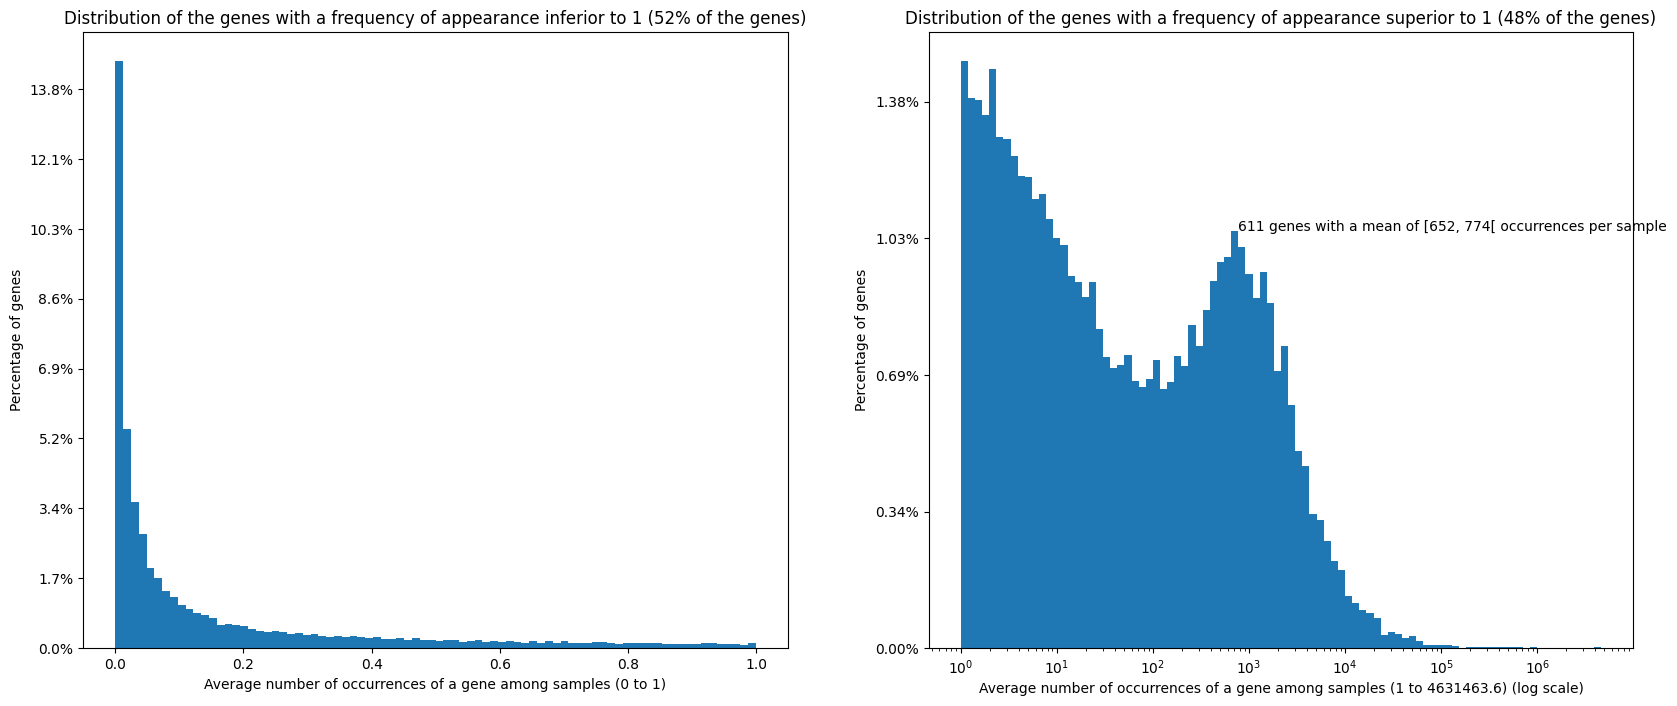

In [14]:
vals = df[df.columns[:n_genes]].mean()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ax[0].hist(vals[vals < 1], bins='auto')
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=n_genes))
ax[0].set_xlabel("Average number of occurrences of a gene among samples (0 to 1)")
ax[0].set_ylabel("Percentage of genes")
ax[0].set_title("Distribution of the genes with a frequency of appearance inferior to 1 (" + str(round(100*len(vals[vals < 1])/n_genes)) + "% of the genes)")

sum_vals = df[df.columns[:n_genes]].sum()
null_genes = sum_vals[sum_vals == 0].index
print(len(null_genes), " genes with no occurrence (", round(100*len(null_genes)/n_genes, 1), "%)", sep='')

val, bins = np.histogram(np.log10(vals + 1), bins='auto')
ax[1].hist(vals, bins=10**bins)
ax[1].set_xscale("log")
ax[1].set_xlabel("Average number of occurrences of a gene among samples (1 to " + str(round(vals.max(), 1)) + ") (log scale)")
ax[1].set_ylabel("Percentage of genes")
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=n_genes))
ax[1].set_title("Distribution of the genes with a frequency of appearance superior to 1 (" + str(round(100*len(vals[vals >= 1])/n_genes)) + "% of the genes)")
for i in range(len(bins)):
	if 10**bins[i] > 100:
		break
local_max = i + np.argmax(val[i:])
max_x, max_y = np.round(10**bins[local_max:local_max+2]), len(vals[(vals > 10**bins[local_max]) & (vals < 10**bins[local_max + 1])])
ax[1].text(max_x[1], max_y, str(max_y) + " genes with a mean of [" + str(round(max_x[0])) + ", " + str(round(max_x[1])) + "[ occurrences per sample")
fig.savefig("img/gene_frequencies.jpg", bbox_inches='tight', pad_inches=0.1)

In [15]:
df.drop(null_genes, axis=1, inplace=True)  # Delete unneccessary columns
selected_genes = df.iloc[:,:n_genes - len(null_genes)]
drop_genes = selected_genes.columns[selected_genes.mean() < 50]
n_selected_genes = n_genes - len(drop_genes) - len(null_genes)
df.drop(drop_genes, axis=1, inplace=True)  # Delete unneccessary genes
print(len(null_genes), " genes with no occurrences removed (", round(100*len(null_genes)/n_genes, 1), " %)\n",
	  len(drop_genes), " genes not frequent enough removed (", round(100*len(drop_genes)/n_genes, 1), " %)", sep='')
df

3677 genes with no occurrences removed (6.3 %)
41346 genes not frequent enough removed (71.2 %)


gene_419  gene_457  gene_460  gene_938  gene_971  gene_1036  \
patient day                                                                
1       0      241.00    123.00     29.00   7831.00     67.00     536.00   
        3      522.50    151.50     60.50  13305.50     35.00     866.00   
        6      685.50    192.00    178.50  13495.50     81.50     754.00   
3       3     1606.00    410.00    143.00   9557.00     70.00     746.00   
        6     1206.00    363.00    151.00  10168.00     62.00     664.00   
...               ...       ...       ...       ...       ...        ...   
499     6     1089.00    395.00    202.00  66925.00    169.00    2010.00   
503     0      990.00    113.00    122.00  41288.00     15.00    1361.00   
        6     1098.00    165.00    204.00  43274.00     70.00    2232.00   
508     3     2449.00   1047.00    197.00  87448.00    130.00    1347.00   
        6     1689.00    495.00    151.00  30118.00    112.00    1664.00   

             gene_1084  gene_1167  gene_1460  gene_1461  ...  gene_283633  \
patient day                                              ...                
1       0       252.00     209.00      32.00     555.00  ...        82.00   
        3       460.50     256.00      33.00     460.00  ...       421.50   
        6       321.00     394.00     106.50     751.00  ...       369.00   
3       3       614.00     625.00     216.00    1925.00  ...       551.00   
        6       560.00     577.00     103.00    1664.00  ...       365.00   
...                ...        ...        ...        ...  ...          ...   
499     6      1661.00    1547.00     162.00    1342.00  ...       574.00   
503     0       421.00     762.00      98.00     689.00  ...        63.00   
        6      1002.00     790.00     140.00     926.00  ...        51.00   
508     3       943.00    2017.00     232.00    2314.00  ...       143.00   
        6      1134.00     631.00     111.00    1439.00  ...       580.00   

             gene_283646  Symptom: acute encephalopathy  Other: shunt failure  \
patient day                                                                     
1       0         192.00                           True                 False   
        3         307.50                           True                 False   
        6         217.00                           True                 False   
3       3          27.00                          False                 False   
        6          17.00                          False                 False   
...                  ...                            ...                   ...   
499     6         171.00                          False                 False   
503     0         279.00                          False                 False   
        6         378.00                          False                 False   
508     3         115.00                          False                 False   
        6          35.00                          False                 False   

             Other: anoxic brain injury  Other: intracerebral hemorrhage  \
patient day                                                                
1       0                         False                            False   
        3                         False                            False   
        6                         False                            False   
3       3                         False                            False   
        6                         False                            False   
...                                 ...                              ...   
499     6                         False                            False   
503     0                         False                            False   
        6                         False                            False   
508     3                         False                            False   
        6                         False                 

#### C) Balance dataset

In [17]:
n_selected_samples = len(df)
n_patients = len(df.index.get_level_values('patient').unique())
n_sick = df['Symptom: acute encephalopathy'].sum()

print("Full data: \n", n_selected_genes, " genes on ", n_selected_samples, " samples of ", n_patients, " patients:\n",
	  n_sick, " samples with acute encephalopathy, ", df['Mild symptoms'].sum(), " with mild symptoms, ", (~(df['Mild symptoms'] + df['Symptom: acute encephalopathy'])).sum(), " healthy samples\n", sep='')
"""
Content of the new dataframe:
First n_sick samples: patients with acute encephalopathy
Rest of the dataset: healthy patients
"""
balanced_df = pd.concat([df[df['Symptom: acute encephalopathy']],
						 df[~df['Symptom: acute encephalopathy']].sample(n=randint(round(n_sick-n_sick*0.1), round(n_sick+n_sick*0.1)))]) #.sample(frac=1)

sum_vals = balanced_df.iloc[:,:n_selected_genes].sum()
null_genes = sum_vals[sum_vals == 0].index
print(len(null_genes), " genes with no occurrence (", round(100*len(null_genes)/n_selected_genes, 1), "%)", sep='')
balanced_df.drop(null_genes, axis=1, inplace=True)  # Delete unneccessary columns

# Keep only genes and acute encephalopagthy columns
balanced_df = balanced_df.iloc[:,:n_selected_genes].assign(acute_encephalopathy=balanced_df['Symptom: acute encephalopathy'])
balanced_df_nv = balanced_df.iloc[:,:-1]  # Keep only genes as dimensions

n_selected_genes = len(balanced_df_nv)
n_selected_samples = len(balanced_df)
n_patients = len(balanced_df.index.get_level_values('patient').unique())
n_sick = balanced_df['acute_encephalopathy'].sum()

balanced_df.to_csv("data/generated/balanced_set.csv")

Full data: 
13028 genes on 432 samples of 176 patients:
114 samples with acute encephalopathy, 95 with mild symptoms, 223 healthy samples

0 genes with no occurrence (0.0%)


In [14]:
print("Input 1:")
input1 = balanced_df_nv.T
input1.to_csv("data/generated/input1.csv")  # Save input 1
input1

Input 1:


patient         1                          5                        25   \
day              0        3        6        3        6        12     3    
gene_419     241.00   522.50   685.50  1295.00   938.00   906.00  12.00   
gene_457     123.00   151.50   192.00   360.00   270.00   197.00   0.00   
gene_460      29.00    60.50   178.50   222.00   144.00   146.50   0.00   
gene_938    7831.00 13305.50 13495.50 21012.00 18808.00 16069.00 155.00   
gene_971      67.00    35.00    81.50   108.00    97.00    92.00   0.00   
...             ...      ...      ...      ...      ...      ...    ...   
gene_283498  252.00   123.50   140.50   270.00   282.00   251.50   2.00   
gene_283602  188.00   125.50    51.00   157.00   120.00    88.50   0.00   
gene_283632   18.00   144.00    56.50   114.00    28.00    34.00   1.00   
gene_283633   82.00   421.50   369.00   745.00   163.00   268.50   5.00   
gene_283646  192.00   307.50   217.00     0.00     6.00     0.00   0.00   

patient                  38       51   ...      9        290      59   \
day               12      0        0   ...       3        6        0    
gene_419      993.00   93.00   369.00  ...   769.00   858.00   828.50   
gene_457      369.00   70.00   243.00  ...   275.00   213.00   387.50   
gene_460      103.00   10.00   184.00  ...   107.00   181.00   279.00   
gene_938    19826.00 3161.00 18997.00  ... 11221.50 32976.00 31002.00   
gene_971      188.00   52.00    71.00  ...   118.00    67.00   174.00   
...              ...     ...      ...  ...      ...      ...      ...   
gene_283498   299.00  195.00    94.00  ...   200.00   277.00   302.00   
gene_283602    46.00   50.00    27.00  ...    44.50    57.00   204.50   
gene_283632    27.00   31.00    12.00  ...    38.50    85.00    34.00   
gene_283633   170.00   44.00   164.00  ...   239.00   691.00   441.00   
gene_283646     9.00  190.00     0.00  ...    28.50   565.00    17.00   

patient          45      145      474      47       262      250      469  
day               6       27       3        0        0        9        12  
gene_419      582.00  281.50  1382.00   412.50   844.00  1193.00  1488.00  
gene_457      116.00   48.50   542.00   232.00   188.00   146.00   556.00  
gene_460      122.00   68.00   171.00   172.50   119.00    99.00   295.00  
gene_938    22209.00 9959.50 60390.00 12151.50 12517.00 42588.00 42488.00  
gene_971       32.00   11.00   199.00    73.00    89.00    43.00   269.00  
...              ...     ...      ...      ...      ...      ...      ...  
gene_283498   164.00   43.00   184.00    60.00   195.00   306.00   309.00  
gene_283602    68.00    9.00   292.00    65.00    76.00   224.00   130.00  
gene_283632    80.00    3.00   196.00    24.50    38.00    65.00   340.00  
gene_283633   420.00   37.50   601.00   137.00   191.00   350.00  1082.00  
gene_283646   201.00   54.00    30.00    90.00     0.00     4.00   164.00  

[13028 rows x 235 columns]

In [15]:
input2 = balanced_df[['Symptom: acute encephalopathy', 'Mild symptoms']].rename(
	columns={'Symptom: acute encephalopathy': 'Acute encephalopathy'})
input2.to_csv("data/generated/input2.csv")  # Save input 2
print("Input 2:")
input2

Input 2:


Acute encephalopathy  Mild symptoms
patient day                                     
1       0                    True          False
        3                    True          False
        6                    True          False
5       3                    True          False
        6                    True          False
...                           ...            ...
474     3                   False          False
47      0                   False          False
262     0                   False           True
250     9                   False           True
469     12                  False          False

[235 rows x 2 columns]

## 3 - Import cleaned data

In [5]:
balanced_df = pd.read_csv("data/generated/balanced_set.csv", index_col=[0, 1])
balanced_df_nv = balanced_df.iloc[:,:-1]  # Keep only genes as dimensions
n_selected_genes = len(balanced_df.columns) - 1
n_selected_samples = len(balanced_df)
n_patients = len(balanced_df.index.get_level_values('patient').unique())
n_sick = balanced_df['acute_encephalopathy'].sum()
balanced_df

gene_419  gene_457  gene_460  gene_938  gene_971  gene_1036  \
patient day                                                                
1       0      241.00    123.00     29.00   7831.00     67.00     536.00   
        3      522.50    151.50     60.50  13305.50     35.00     866.00   
        6      685.50    192.00    178.50  13495.50     81.50     754.00   
5       3     1295.00    360.00    222.00  21012.00    108.00    1607.00   
        6      938.00    270.00    144.00  18808.00     97.00    1426.00   
...               ...       ...       ...       ...       ...        ...   
262     3     1305.00    257.00    211.00  24708.00     77.00    2066.00   
237     21    1639.00    418.00    359.00  19448.00    288.00    1997.00   
161     0      754.00    367.50    393.50  13019.00     37.50    1216.50   
111     0     1359.00    549.00    255.50  10853.50    447.00    1209.50   
229     3      934.00    161.00    204.00   8403.00    194.00     853.00   

             gene_1084  gene_1167  gene_1460  gene_1461  ...  gene_283050  \
patient day                                              ...                
1       0       252.00     209.00      32.00     555.00  ...        30.00   
        3       460.50     256.00      33.00     460.00  ...         9.00   
        6       321.00     394.00     106.50     751.00  ...        22.50   
5       3       460.00     515.00     110.00    1021.00  ...        72.00   
        6       407.00     585.00      72.00     811.00  ...        40.00   
...                ...        ...        ...        ...  ...          ...   
262     3       861.00     675.00      84.00    1006.00  ...        28.00   
237     21     1146.00    1257.00     215.00    1816.00  ...        69.00   
161     0      1471.50    1459.50      98.00    1129.50  ...       212.00   
111     0       774.50     893.00     140.00    1596.00  ...       283.00   
229     3       625.00     731.00     105.00     886.00  ...        36.00   

             gene_283063  gene_283199  gene_283378  gene_283498  gene_283602  \
patient day                                                                    
1       0         103.00       392.00         2.00       252.00       188.00   
        3          46.00        71.50         7.50       123.50       125.50   
        6         205.00        91.00        12.50       140.50        51.00   
5       3         126.00        50.00         5.00       270.00       157.00   
        6         107.00        75.00         6.00       282.00       120.00   
...                  ...          ...          ...          ...          ...   
262     3          53.00        94.00        14.00       468.00       117.00   
237     21        360.00       112.00        35.00       773.00        65.00   
161     0          46.00       689.50        19.50       145.50       103.00   
111     0         187.00      1087.50         2.00       349.50        85.50   
229     3          41.00       165.00        15.00       292.00        42.00   

             gene_283632  gene_283633  gene_283646  acute_encephalopathy  
patient day                                                               
1       0          18.00        82.00       192.00                  True  
        3         144.00       421.50       307.50                  True  
        6          56.50       369.00       217.00                  True  
5       3         114.00       745.00         0.00                  True  
        6          28.00       163.00         6.00                  True  
...                  ...          ...          ...                   ...  
262     3          79.00      1660.00        11.00                 False  
237     21        117.00      1351.00         5.00                 False  
161     0          57.00       683.50         8.00                 False  
111     0          51.00       270.50         1.00                 False  
229     3          51.00       900.00         0.00                 False  

[230 

## 4 - First analysis of the selected data
### 1) Dataset information

In [20]:
print("Balanced dataset: \n", n_selected_genes, " genes on ", n_selected_samples, " samples of ", n_patients, " patients:\n",
	  n_sick, " samples with acute encephalopathy, ", n_selected_samples - n_sick, ' "healthy" samples\n\nGene quantities:\nMean of ',
	  round(balanced_df_nv.mean().mean()), " and median of ", round(balanced_df_nv.median().median()), "\n",
	  round(100*(balanced_df_nv == 0).sum().sum()/(len(balanced_df_nv)*len(balanced_df_nv.columns)), 1), "% of null values\n", sep='')
balanced_df

Balanced dataset: 
13028 genes on 230 samples of 111 patients:
114 samples with acute encephalopathy, 116 "healthy" samples

Gene quantities:
Mean of 2703 and median of 462
0.9% of null values



gene_419  gene_457  gene_460  gene_938  gene_971  gene_1036  \
patient day                                                                
1       0      241.00    123.00     29.00   7831.00     67.00     536.00   
        3      522.50    151.50     60.50  13305.50     35.00     866.00   
        6      685.50    192.00    178.50  13495.50     81.50     754.00   
5       3     1295.00    360.00    222.00  21012.00    108.00    1607.00   
        6      938.00    270.00    144.00  18808.00     97.00    1426.00   
...               ...       ...       ...       ...       ...        ...   
262     3     1305.00    257.00    211.00  24708.00     77.00    2066.00   
237     21    1639.00    418.00    359.00  19448.00    288.00    1997.00   
161     0      754.00    367.50    393.50  13019.00     37.50    1216.50   
111     0     1359.00    549.00    255.50  10853.50    447.00    1209.50   
229     3      934.00    161.00    204.00   8403.00    194.00     853.00   

             gene_1084  gene_1167  gene_1460  gene_1461  ...  gene_283050  \
patient day                                              ...                
1       0       252.00     209.00      32.00     555.00  ...        30.00   
        3       460.50     256.00      33.00     460.00  ...         9.00   
        6       321.00     394.00     106.50     751.00  ...        22.50   
5       3       460.00     515.00     110.00    1021.00  ...        72.00   
        6       407.00     585.00      72.00     811.00  ...        40.00   
...                ...        ...        ...        ...  ...          ...   
262     3       861.00     675.00      84.00    1006.00  ...        28.00   
237     21     1146.00    1257.00     215.00    1816.00  ...        69.00   
161     0      1471.50    1459.50      98.00    1129.50  ...       212.00   
111     0       774.50     893.00     140.00    1596.00  ...       283.00   
229     3       625.00     731.00     105.00     886.00  ...        36.00   

             gene_283063  gene_283199  gene_283378  gene_283498  gene_283602  \
patient day                                                                    
1       0         103.00       392.00         2.00       252.00       188.00   
        3          46.00        71.50         7.50       123.50       125.50   
        6         205.00        91.00        12.50       140.50        51.00   
5       3         126.00        50.00         5.00       270.00       157.00   
        6         107.00        75.00         6.00       282.00       120.00   
...                  ...          ...          ...          ...          ...   
262     3          53.00        94.00        14.00       468.00       117.00   
237     21        360.00       112.00        35.00       773.00        65.00   
161     0          46.00       689.50        19.50       145.50       103.00   
111     0         187.00      1087.50         2.00       349.50        85.50   
229     3          41.00       165.00        15.00       292.00        42.00   

             gene_283632  gene_283633  gene_283646  acute_encephalopathy  
patient day                                                               
1       0          18.00        82.00       192.00                  True  
        3         144.00       421.50       307.50                  True  
        6          56.50       369.00       217.00                  True  
5       3         114.00       745.00         0.00                  True  
        6          28.00       163.00         6.00                  True  
...                  ...          ...          ...                   ...  
262     3          79.00      1660.00        11.00                 False  
237     21        117.00      1351.00         5.00                 False  
161     0          57.00       683.50         8.00                 False  
111     0          51.00       270.50         1.00                 False  
229     3          51.00       900.00         0.00                 False  

[230 

Input 2 information

In [6]:
print("Content of input 2:")
stats = input2.value_counts()
for i, val in stats.items():
	stats[i] = str(round(100*val/len(input2))) + ' %'
stats.name = "occurrences"
stats

Content of input 2:


NameError: name 'input2' is not defined

### 2) PCA


Explained variation per principal component:
PC1: 97.89%
PC2: 0.72%
PC3: 0.34%
PC4: 0.26%%
Data lost: 0.8%



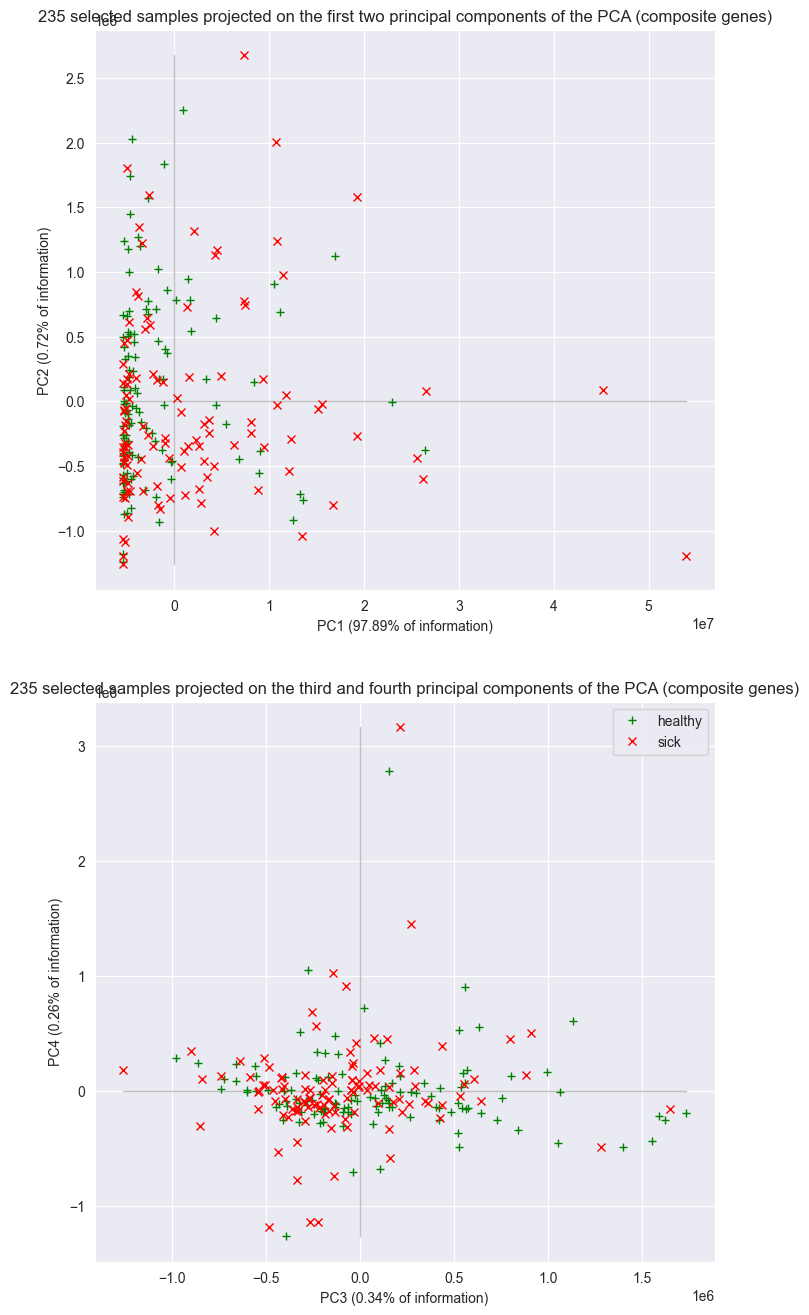

In [18]:
#df_pca = StandardScaler().fit_transform(df_pca)  # Center-reduce the data
pca = PCA(n_components=4)

df_pca = pca.fit_transform(balanced_df_nv)  # Apply the PCA
df_pca = pd.DataFrame(df_pca, columns=['PC' + str(i+1) for i in range(df_pca.shape[1])])
#df_pca['acute_encephalopathy'] = balanced_df['acute_encephalopathy']  # Adding the outcome column

# Displaying PCA performance
variance = [pca.explained_variance_ratio_[i]*100 for i in range(df_pca.shape[1])]
print("\nExplained variation per principal component:", ''.join('\nPC' + str(i+1) + ': ' + str(round(variance[i], 2)) + '%' for i in range(df_pca.shape[1])),
	  "%\nData lost: ", round(100-sum(variance), 2), "%\n", sep='')

# Graphical display
fig, axes = plt.subplots(2, figsize=(8, 16))
axes[0].plot([df_pca.PC1.min(), df_pca.PC1.max()], [0, 0], color='silver', linestyle='-', linewidth=1)
axes[0].plot([0, 0], [df_pca.PC2.min(), df_pca.PC2.max()], color='silver', linestyle='-', linewidth=1)
axes[1].plot([df_pca.PC3.min(), df_pca.PC3.max()], [0, 0], color='silver', linestyle='-', linewidth=1)
axes[1].plot([0, 0], [df_pca.PC4.min(), df_pca.PC4.max()], color='silver', linestyle='-', linewidth=1)

# Codes pour affichage graphique
style = {False: ('healthy', 'g+'),  # Patient not having acute encephalopathy
         True: ('sick', 'rx')}  # Patient having acute encephalopathy

# Adding points
for outcome in {False, True}:

  # Selecting points with the same outcome
  df_pca_temp = df_pca[(balanced_df['acute_encephalopathy'] == outcome).values]

  # Displaying points
  axes[0].plot(df_pca_temp.PC1, df_pca_temp.PC2, style[outcome][1], label=style[outcome][0])
  axes[1].plot(df_pca_temp.PC3, df_pca_temp.PC4, style[outcome][1], label=style[outcome][0])

axes[0].set_xlabel("PC1 ("+ str(round(variance[0], 2)) + "% of information)")
axes[0].set_ylabel("PC2 ("+ str(round(variance[1], 2)) + "% of information)")
axes[0].set_title(str(len(balanced_df_nv)) + " selected samples projected on the first two principal components of the PCA (composite genes)")
axes[1].set_xlabel("PC3 ("+ str(round(variance[2], 2)) + "% of information)")
axes[1].set_ylabel("PC4 ("+ str(round(variance[3], 2)) + "% of information)")
axes[1].set_title(str(len(balanced_df_nv)) + " selected samples projected on the third and fourth principal components of the PCA (composite genes)")
plt.legend(loc='upper right')
plt.savefig("img/PCA.jpg", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [19]:
# n = balanced_df_nv.shape[0]  #Nombre de fleur observée
# p = balanced_df_nv.shape[1]  #Nombre de variables
#
# ValPropres = pca.explained_variance_
# SqrtValPropres = np.sqrt(ValPropres)
# print((p, p))
# CorrVar = np.zeros((p, p))
#
# for j in range(p):
# 	print(j)
# 	CorrVar[:, j] = pca.components_[j, :] * SqrtValPropres[j]
#
# fig, axes = plt.subplots(figsize=(10, 10))
# axes.set_xlim(-1.2, 1.2)
# axes.set_ylim(-1.2, 1.2)
# axes.set_xlabel("PC1")
# axes.set_ylabel("PC2")
#
# for k in range(p):
#     #plt.annotate(balanced_df_nv.columns[k], (CorrVar[k, 0], CorrVar[k, 1]))
#     axes.arrow(0, 0, CorrVar[k, 0], CorrVar[k, 1], head_width=0.05, head_length=0.05, color="cyan")
#
# plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
# plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)
# plt.title("Cercle de corrélation")
# circle = plt.Circle((0, 0), 1, color="blue", fill=False)
# axes.add_artist(circle)
#
# plt.show()

# II - PCA UFE
Based on this work: [**PCA-based unsupervised feature extraction**](https://www.kaggle.com/code/yoshifumimiya/pca-based-unsupervised-feature-extraction)

## 1 - The PCA
PCA on dataset with sample as rows and genes as columns (reverse of normal PCA)

In [20]:
pca = PCA()  # Initialize a PCA object
pca.fit(input1)  # Fit the PCA model with the dataset

# Get the composition of the principal components
# (How much each feature is used in each principal component)
PC_names = ['sample ' + str(i+1) for i in range(len(balanced_df_nv))]
compositions = pd.DataFrame(pca.components_.T,
							index=balanced_df_nv.index,
							columns=PC_names)
compositions

sample 1  sample 2  sample 3  sample 4  sample 5  sample 6  \
patient day                                                               
1       0        0.03      0.04     -0.00      0.15      0.02     -0.00   
        3        0.06      0.02     -0.01      0.06      0.00     -0.06   
        6        0.03      0.04     -0.03      0.01     -0.02     -0.05   
5       3        0.00      0.07     -0.05     -0.01     -0.05      0.00   
        6        0.00      0.06     -0.04     -0.02     -0.04      0.01   
...               ...       ...       ...       ...       ...       ...   
474     3        0.02      0.13      0.03      0.04      0.02     -0.13   
47      0        0.03      0.02     -0.09     -0.01      0.18     -0.03   
262     0        0.00      0.04     -0.03     -0.02     -0.04      0.02   
250     9        0.01      0.11      0.14      0.03      0.07     -0.03   
469     12       0.04      0.10     -0.10      0.01     -0.08     -0.02   

             sample 7  sample 8  sample 9  sample 10  ...  sample 226  \
patient day                                           ...               
1       0       -0.00      0.07     -0.03       0.00  ...        0.04   
        3       -0.02      0.06     -0.01       0.01  ...        0.07   
        6       -0.01      0.05      0.02       0.00  ...       -0.14   
5       3       -0.01      0.04      0.01      -0.01  ...        0.04   
        6       -0.02     -0.03      0.03      -0.01  ...       -0.07   
...               ...       ...       ...        ...  ...         ...   
474     3        0.03     -0.14     -0.01      -0.13  ...       -0.00   
47      0        0.01      0.04     -0.01       0.11  ...       -0.01   
262     0       -0.05      0.01     -0.02       0.02  ...        0.02   
250     9       -0.04     -0.03     -0.07       0.00  ...        0.01   
469     12      -0.03     -0.05      0.04      -0.04  ...        0.01   

             sample 227  sample 228  sample 229  sample 230  sample 231  \
patient day                                                               
1       0          0.02        0.04        0.06        0.01       -0.00   
        3          0.00       -0.06        0.01       -0.06       -0.14   
        6          0.06        0.26       -0.01       -0.04        0.13   
5       3          0.02       -0.23        0.14       -0.09       -0.00   
        6          0.24        0.25       -0.38        0.15        0.03   
...                 ...         ...         ...         ...         ...   
474     3          0.00       -0.02       -0.01        0.00        0.01   
47      0         -0.03        0.00       -0.01       -0.01        0.00   
262     0          0.02        0.10        0.01       -0.11        0.03   
250     9         -0.00       -0.00        0.01        0.01        0.02   
469     12        -0.00        0.02       -0.01       -0.01       -0.01   

             sample 232  sample 233  sample 234  sample 235  
patient day                                                  
1       0          0.11        0.04        0.02        0.00  
        3          0.03       -0.00       -0.02       -0.00  
        6         -0.09        0.01        0.00        0.00  
5       3         -0.02        0.01       -0.01        0.00  
        6          0.17       -0.01        0.01       -0.00  
...                 ...         ...         ...         ...  
474     3          0.01       -0.00       -0.00        0.00  
47      0          0.00       -0.02        0.01       -0.00  
262     0          0.04       -0.02        0.01       -0.00  
250     9         -0.01       -0.00        0.01       -0.00  
469     12        -0.00       -0.00       -0.00       -0.00  

[235 rows x 235 columns]

In [21]:
# Apply dimensionality reduction to X
# (Rewrite X coordinates using the principal components reference frame)
df_transf = pd.DataFrame(pca.transform(input1), index=balanced_df_nv.columns, columns=PC_names)
df_transf

sample 1  sample 2  sample 3  sample 4  sample 5  sample 6  \
gene_419    -24978.91 -15179.10   5410.46    210.51  -3368.95    943.38   
gene_457    -31852.18 -26624.99   5459.24   1808.08  -2700.07  -3272.83   
gene_460    -32556.62 -28104.70   5939.09   1987.54  -2797.25  -3545.82   
gene_938    156405.82 318304.73 -10017.47 -25436.95  30439.20   1084.24   
gene_971    -32938.45 -28592.41   6129.04   2134.58  -3321.09  -3489.23   
...               ...       ...       ...       ...       ...       ...   
gene_283498 -31706.07 -26896.37   6323.54   2098.00  -3652.75  -2638.57   
gene_283602 -32780.55 -28315.66   7155.29   2298.09  -3426.30  -3536.59   
gene_283632 -33020.12 -28990.85   6731.35   2439.09  -3728.34  -4330.33   
gene_283633 -30291.80 -24412.13   4532.26   1843.07  -3065.95  -4717.89   
gene_283646 -32803.80 -28987.37   7420.70   2871.83  -3408.67  -4656.13   

             sample 7  sample 8  sample 9  sample 10  ...  sample 226  \
gene_419      -483.30   1585.22    211.78      -1.04  ...      -29.61   
gene_457      -995.24    626.05   -163.51    -874.84  ...       -1.46   
gene_460      -871.45   1132.68    -40.56    -638.68  ...      -13.49   
gene_938      7506.52 -68327.21   9119.14  -28292.03  ...      223.17   
gene_971     -1253.68    838.54    191.33    -625.14  ...        7.72   
...               ...       ...       ...        ...  ...         ...   
gene_283498  -1172.04   1452.92    399.12    -274.71  ...      -12.72   
gene_283602  -1167.69    537.31   -271.35    -799.31  ...       25.91   
gene_283632   -847.40    856.80   -219.36    -556.28  ...      -10.57   
gene_283633   -267.17   2334.37   -543.25    -416.31  ...        7.72   
gene_283646   -974.15   1520.63    551.49    -414.34  ...       -3.11   

             sample 227  sample 228  sample 229  sample 230  sample 231  \
gene_419          28.87       20.79      -56.58       14.50       14.02   
gene_457          10.23        7.25        4.73      -13.01      -30.35   
gene_460         -14.53       34.13       18.77       -2.46       -8.37   
gene_938         446.58      889.92      419.16      149.29     -111.84   
gene_971         -25.73      -17.59        8.98       -0.96       15.61   
...                 ...         ...         ...         ...         ...   
gene_283498       36.12       -2.59      -25.42       14.86      -14.09   
gene_283602       -2.18        8.28        8.18        4.94       -7.30   
gene_283632      -15.93      -40.66      -26.32       16.87      -25.99   
gene_283633      -97.84       -4.56       -5.51       35.74       22.95   
gene_283646       11.07      -40.00      -33.75      -37.88        4.84   

             sample 232  sample 233  sample 234  sample 235  
gene_419          19.98      -17.03      -29.96        3.57  
gene_457           6.53       -2.23       -4.70       -1.58  
gene_460         -43.18      -13.60       11.79       -1.14  
gene_938         719.52     -414.09      126.25       16.59  
gene_971          -6.59       14.83       -1.20       -1.17  
...                 ...         ...         ...         ...  
gene_283498        8.62       24.32        6.37       -0.14  
gene_283602       17.11        6.19        4.04       -1.84  
gene_283632      -15.57       -7.12       12.11       -0.15  
gene_283633      -24.65       43.60       -7.00        2.25  
gene_283646      -15.09       75.55       -3.62       -2.12  

[13028 rows x 235 columns]

In [22]:
# Displaying PCA performance
print("\nPercentage of total information contained by each principal component (composite sample):")
variance = pd.Series([pca.explained_variance_ratio_[i]*100 for i in range(len(df_transf.columns))],
					 name='Explained variation', index=PC_names)
variance


Percentage of total information contained by each principal component (composite sample):


sample 1     97.25
sample 2      1.75
sample 3      0.26
sample 4      0.18
sample 5      0.17
              ... 
sample 231    0.00
sample 232    0.00
sample 233    0.00
sample 234    0.00
sample 235    0.00
Name: Explained variation, Length: 235, dtype: float64

## 2 - Selection of the composite samples
Select the two composite samples that best differentiate sick samples from healthy samples
Compute p-values using [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test) and select the two axes with the lowest p-values

In [23]:
PC_pvalues = pd.Series([ttest_ind(compositions.iloc[:n_sick,i],
								  compositions.iloc[n_sick:,i], equal_var=True)[1]
					  for i in range(compositions.shape[1])],
					 index=compositions.columns, name="p-value")
PC_pvalues.sort_values(inplace=True)
PC_pvalues

sample 2     0.00
sample 1     0.00
sample 106   0.00
sample 198   0.00
sample 152   0.01
             ... 
sample 21    0.99
sample 59    0.99
sample 207   1.00
sample 214   1.00
sample 206   1.00
Name: p-value, Length: 235, dtype: float64

In [24]:
first_PC, second_PC = PC_pvalues.index[:2]
print("Samples chosen:\n", first_PC, " (p-value of ", PC_pvalues[first_PC],
	  ")\n", second_PC, " (p-value of ", PC_pvalues[second_PC], ")", sep='')
pd.concat([df_transf[first_PC], df_transf[second_PC]], axis=1)

Samples chosen:
sample 2 (p-value of 7.292675183302325e-05)
sample 1 (p-value of 0.00034132701209242135)


sample 2  sample 1
gene_419    -15179.10 -24978.91
gene_457    -26624.99 -31852.18
gene_460    -28104.70 -32556.62
gene_938    318304.73 156405.82
gene_971    -28592.41 -32938.45
...               ...       ...
gene_283498 -26896.37 -31706.07
gene_283602 -28315.66 -32780.55
gene_283632 -28990.85 -33020.12
gene_283633 -24412.13 -30291.80
gene_283646 -28987.37 -32803.80

[13028 rows x 2 columns]

**Note:**
Samples 1 and 106 give only 161 DEG
Samples 1 and 2 give only 38 genes

## 3 - Selection of the Differentially Expressed Genes
Standardization, squaring, and summing of the data on the selected composite samples

In [25]:
first_composite_sample = df_transf.loc[:,first_PC]
second_composite_sample = df_transf.loc[:,second_PC]
dat = ((first_composite_sample - first_composite_sample.mean()) / first_composite_sample.std())**2 + \
	  ((second_composite_sample - second_composite_sample.mean()) / second_composite_sample.std())**2
dat

gene_419      0.01
gene_457      0.02
gene_460      0.03
gene_938      3.19
gene_971      0.03
              ... 
gene_283498   0.02
gene_283602   0.03
gene_283632   0.03
gene_283633   0.02
gene_283646   0.03
Length: 13028, dtype: float64

Test of the goodness of fit of values with a [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) with two degrees of freedom and adjustment of the p-values with the [Benjamini–Hochberg (BH) procedure](https://en.wikipedia.org/wiki/False_discovery_rate#BH_procedure)

**Note**: the chi-squared test is used to compare the distribution of certain properties of genes (e.g., genomic content, mutation rate, interaction network clustering, etc.) belonging to different categories (e.g., disease genes, essential genes, genes on a certain chromosome etc.) ([Chi-squared test applications](https://en.wikipedia.org/wiki/Chi-squared_test#Applications))

In [26]:
p_values = chi2.pdf(dat, 2)
print("P-values of the chi-squared test:", p_values, "\n\nFinal p-values:")
RES = pd.Series(multipletests(p_values, method='fdr_bh')[1], index=balanced_df_nv.columns)
RES.sort_values()

P-values of the chi-squared test: [0.49811102 0.4943369  0.49370385 ... 0.49330847 0.4952258  0.49331201] 

Final p-values:


gene_163220   0.00
gene_244734   0.00
gene_75624    0.00
gene_166710   0.00
gene_143546   0.00
              ... 
gene_129450   0.50
gene_129460   0.50
gene_129465   0.50
gene_129292   0.50
gene_283646   0.50
Length: 13028, dtype: float64

Selection of the Differentially Expressed Genes (DEG) Using the P-value: [Q-value section Gene expression](https://en.wikipedia.org/wiki/Q-value_(statistics)?wprov=srpw1_2#Gene_expression)

In [27]:
PCAUFE_DEG = RES.index[RES < 0.01]
print(len(PCAUFE_DEG), " differentially expressed genes detected (", round(100*len(DEG)/len(RES), 2), "%)", sep='')
df_transf["label"] = "non-PCAUFE_DEG"
df_transf.loc[PCAUFE_DEG, 'label'] = "DEG"
PCAUFE_DEG.tolist()

38 differentially expressed genes detected (0.29%)


['gene_12223',
 'gene_19582',
 'gene_30582',
 'gene_75624',
 'gene_85265',
 'gene_87086',
 'gene_90382',
 'gene_103187',
 'gene_111348',
 'gene_120129',
 'gene_132475',
 'gene_136167',
 'gene_143546',
 'gene_156508',
 'gene_160255',
 'gene_163131',
 'gene_163220',
 'gene_166710',
 'gene_167996',
 'gene_170345',
 'gene_172757',
 'gene_185201',
 'gene_188536',
 'gene_197746',
 'gene_198804',
 'gene_204525',
 'gene_204592',
 'gene_205542',
 'gene_206172',
 'gene_206503',
 'gene_210082',
 'gene_211592',
 'gene_211895',
 'gene_211896',
 'gene_234745',
 'gene_244734',
 'gene_251562',
 'gene_265972']

In [21]:
with open('data/generated/PCAUFE_DEG.pyc', 'wb') as file:
    pickle.dump(PCAUFE_DEG.tolist(), file)

NameError: name 'PCAUFE_DEG' is not defined

## 3 - Graphical interpretation

non-DEG
DEG


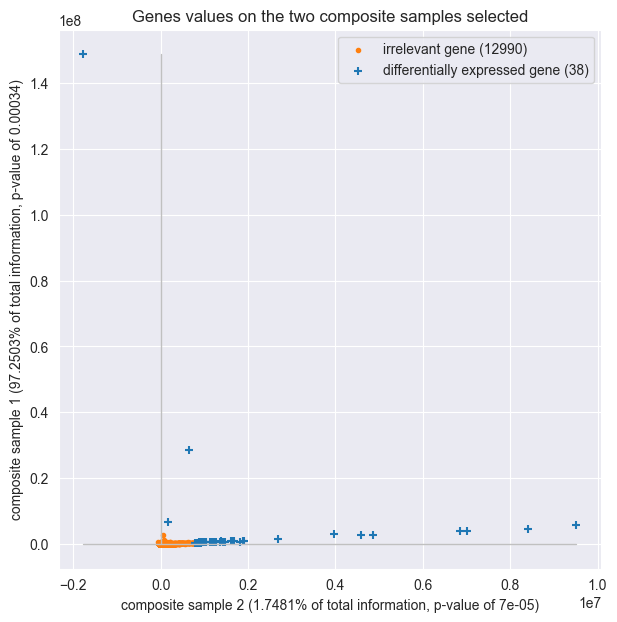

In [28]:
# Graphical display
plt.figure(figsize=(7, 7))
plt.plot([df_transf[first_PC].min(), df_transf[first_PC].max()], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [df_transf[second_PC].min(), df_transf[second_PC].max()], color='silver', linestyle='-', linewidth=1)

groups = df_transf.groupby('label', sort=False)
for name, group in groups:
	print(name)
	label = "differentially expressed" if name == 'DEG' else "irrelevant"
	plt.scatter(group[first_PC], group[second_PC], marker=('+' if name == 'DEG' else '.'), c=('#1f77b4' if name == 'DEG' else '#ff7f0e'), label=label + " gene (" + str(len(group)) + ")")
plt.title("Genes values on the two composite samples selected")
plt.xlabel("composite " + first_PC + " ("+ str(round(variance[first_PC], 4)) + "% of total information, p-value of " + str(round(PC_pvalues[first_PC], 5)) + ")")
plt.ylabel("composite " + second_PC + " ("+ str(round(variance[second_PC], 4)) + "% of total information, p-value of " + str(round(PC_pvalues[second_PC], 5)) + ")")
plt.legend()
plt.savefig("img/cols = DEG.jpg", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [29]:
df_transf.groupby('label').sum()

sample 1     sample 2    sample 3    sample 4   sample 5  \
label                                                                   
DEG      230508296.01  79935206.79 -7349946.14  1814137.75  500215.91   
non-DEG -230508296.01 -79935206.79  7349946.14 -1814137.75 -500215.91   

           sample 6    sample 7   sample 8   sample 9  sample 10  ...  \
label                                                             ...   
DEG      6265300.78  2296737.88  977941.83 -283330.65  -39265.70  ...   
non-DEG -6265300.78 -2296737.88 -977941.83  283330.65   39265.70  ...   

         sample 226  sample 227  sample 228  sample 229  sample 230  \
label                                                                 
DEG        -2267.01     3932.39      532.64      133.79     3144.48   
non-DEG     2267.01    -3932.39     -532.64     -133.79    -3144.48   

         sample 231  sample 232  sample 233  sample 234  sample 235  
label                                                                
DEG         1234.81     1752.82     -588.14     -890.84      -11.36  
non-DEG    -1234.81    -1752.82      588.14      890.84       11.36  

[2 rows x 235 columns]

https://medium.com/omics-diary/building-volcano-plots-with-plotly-for-quantitative-analysis-of-omics-data-74e36f4cb8f8
https://www.reneshbedre.com/blog/volcano.html
https://www.atlanticeditsandgraphics.com/2018/05/24/volcano-plots/

In [30]:
"""
corr = df.corr()  # Calcul des corrélations entre les colonnes du jeu de données

# Filtrage des corrélations intéressantes
#corr.drop([], inplace=True, axis=1)
#corr.drop([], inplace=True, axis=0)

threshold = 67

# Initialisation des graphiques
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 22))

# Configuration de la taille du texte sur les graphiques
#
figure.tight_layout(h_pad=16)
plt.rcParams['font.size'] = '30'
for labels in (ax1.get_xticklabels() + ax1.get_yticklabels(), ax2.get_xticklabels() + ax2.get_yticklabels()):
	for label in labels:
		label.set_fontsize(30)
#

# Tracé des graphiques
h1 = sns.heatmap(abs(corr*100), annot=True, ax=ax2, mask = corr.applymap(lambda x: True if abs(x) < threshold/100 else False),fmt='.1f')
ax2.set_title("Correlation table between the various parameters", fontsize=30)
#h2 = sns.heatmap(corr*100, annot=True, ax=ax2, mask = corr.applymap(lambda x: True if abs(x) < threshold/100 else False), center=0,fmt='.1f')
#ax2.set_title("Correlation table between the Red Line (RL) color range and the image average color (%)", fontsize=30)

plt.subplots_adjust(hspace=0.5)

plt.show()
"""

'\ncorr = df.corr()  # Calcul des corrélations entre les colonnes du jeu de données\n\n# Filtrage des corrélations intéressantes\n#corr.drop([], inplace=True, axis=1)\n#corr.drop([], inplace=True, axis=0)\n\nthreshold = 67\n\n# Initialisation des graphiques\nfigure, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 22))\n\n# Configuration de la taille du texte sur les graphiques\n#\nfigure.tight_layout(h_pad=16)\nplt.rcParams[\'font.size\'] = \'30\'\nfor labels in (ax1.get_xticklabels() + ax1.get_yticklabels(), ax2.get_xticklabels() + ax2.get_yticklabels()):\n\tfor label in labels:\n\t\tlabel.set_fontsize(30)\n#\n\n# Tracé des graphiques\nh1 = sns.heatmap(abs(corr*100), annot=True, ax=ax2, mask = corr.applymap(lambda x: True if abs(x) < threshold/100 else False),fmt=\'.1f\')\nax2.set_title("Correlation table between the various parameters", fontsize=30)\n#h2 = sns.heatmap(corr*100, annot=True, ax=ax2, mask = corr.applymap(lambda x: True if abs(x) < threshold/100 else False), center=0,fmt=\'

## 4 - Import saved DEG selection

In [6]:
with open('data/generated/PCAUFE_DEG.pyc', 'rb') as file:
    PCAUFE_DEG = pickle.load(file)

print(len(PCAUFE_DEG), "DEG imported")

38 DEG imported


# III - Prediction using logistic regression
## 1 - Creating training, validation and test sets

In [10]:
# Create test and validation set
X_train, X_test, y_train, y_test = train_test_split(balanced_df_nv, balanced_df['acute_encephalopathy'], test_size=0.2, random_state=1)
y_train.name = 'sick'

# Extract a validation set from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((156, 13028), (28, 13028), (46, 13028))

## 2 - first DEG identification: PCA-UFE & VIF
### A) Restrict PCA-UFE's DEG list using the VIF test

In [9]:
VIF_DEG = PCAUFE_DEG.copy()
vif = [variance_inflation_factor(balanced_df_nv[VIF_DEG].values, i) for i in range(len(VIF_DEG))]  # Compute the VIF of the selected genes
max_vif = max(vif)  # Select the gene with the worst VIF


while not isinf(max_vif) and max_vif >= 10:

    # Remove the gene with the worst VIF
    idx = vif.index(max_vif)
    print("Dropping ", VIF_DEG[idx], " (VIF of ", round(max_vif), ")", sep='')
    del VIF_DEG[idx]

    vif = [variance_inflation_factor(balanced_df_nv[VIF_DEG].values, i) for i in range(len(VIF_DEG))]  # Compute the VIF of the selected genes
    max_vif = max(vif)  # Select the gene with the worst VIF

if isinf(max_vif):
	print("VIF inoperable: returns infinite value")

print(len(PCAUFE_DEG) - len(vif), "genes removed,", len(vif), "remaining")
pd.Series(vif, index=VIF_DEG, name="VIF").sort_values(ascending=False)

Dropping gene_172757 (VIF of 325)
Dropping gene_103187 (VIF of 185)
Dropping gene_111348 (VIF of 173)
Dropping gene_163220 (VIF of 169)
Dropping gene_166710 (VIF of 145)
Dropping gene_160255 (VIF of 143)
Dropping gene_197746 (VIF of 108)
Dropping gene_136167 (VIF of 79)
Dropping gene_204592 (VIF of 68)
Dropping gene_30582 (VIF of 56)
Dropping gene_87086 (VIF of 48)
Dropping gene_132475 (VIF of 47)
Dropping gene_206503 (VIF of 45)
Dropping gene_163131 (VIF of 41)
Dropping gene_188536 (VIF of 40)
Dropping gene_205542 (VIF of 37)
Dropping gene_120129 (VIF of 31)
Dropping gene_234745 (VIF of 26)
Dropping gene_75624 (VIF of 23)
Dropping gene_211592 (VIF of 20)
Dropping gene_156508 (VIF of 19)
Dropping gene_204525 (VIF of 17)
Dropping gene_167996 (VIF of 13)
Dropping gene_206172 (VIF of 13)
Dropping gene_85265 (VIF of 11)
25 genes removed, 13 remaining


gene_143546   7.58
gene_265972   7.24
gene_19582    6.35
gene_185201   5.43
gene_211896   5.30
gene_211895   5.24
gene_170345   4.44
gene_251562   3.91
gene_198804   3.44
gene_90382    3.10
gene_210082   2.77
gene_12223    2.67
gene_244734   1.34
Name: VIF, dtype: float64

# For all genes

In [10]:
models, predictions = LazyClassifier().fit(x_train, x_val, y_train, y_val)
models.sort_values("Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:47<00:00,  1.63s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.78               0.78     0.78      0.78   
PassiveAggressiveClassifier        0.77               0.77     0.77      0.76   
LGBMClassifier                     0.75               0.75     0.75      0.75   
RandomForestClassifier             0.74               0.74     0.74      0.74   
LogisticRegression                 0.73               0.73     0.73      0.73   
LinearDiscriminantAnalysis         0.73               0.73     0.73      0.72   
SGDClassifier                      0.71               0.71     0.71      0.71   
CalibratedClassifierCV             0.71               0.71     0.71      0.71   
ExtraTreeClassifier                0.70               0.70     0.70      0.70   
RidgeClassifierCV                  0.70               0.70     0.70      0.70   
Perceptron                         0.70               0.70     0.70      0.70   
SVC                                0.69               0.69     0.69      0.68   
KNeighborsClassifier               0.69               0.69     0.69      0.69   
ExtraTreesClassifier               0.69               0.69     0.69      0.69   
LinearSVC                          0.69               0.69     0.69      0.69   
NuSVC                              0.68               0.68     0.68      0.68   
BaggingClassifier                  0.68               0.68     0.68      0.68   
RidgeClassifier                    0.68               0.68     0.68      0.68   
GaussianNB                         0.65               0.65     0.65      0.65   
AdaBoostClassifier                 0.65               0.65     0.65      0.65   
NearestCentroid                    0.65               0.65     0.65      0.65   
BernoulliNB                        0.61               0.61     0.61      0.61   
DecisionTreeClassifier             0.56               0.56     0.56      0.56   
LabelSpreading                     0.51               0.50     0.50      0.34   
LabelPropagation                   0.51               0.50     0.50      0.34   
DummyClassifier                    0.51               0.50     0.50      0.34   
QuadraticDiscriminantAnalysis      0.48               0.48     0.48      0.48   

                               Time Taken  
Model                                      
XGBClassifier                        2.58  
PassiveAggressiveClassifier          0.48  
LGBMClassifier                       3.33  
RandomForestClassifier               0.71  
LogisticRegression                   0.65  
LinearDiscriminantAnalysis           0.94  
SGDClassifier                        0.34  
CalibratedClassifierCV              14.48  
ExtraTreeClassifier                  0.29  
RidgeClassifierCV                    0.35  
Perceptron                           0.35  
SVC                                  1.29  
KNeighborsClassifier                 0.43  
ExtraTreesClassifier                 0.49  
LinearSVC                            3.16  
NuSVC                                1.30  
BaggingClassifier                    3.19  
RidgeClassifier                      0.32  
GaussianNB                           0.38  
AdaBoostClassifier                   8.91  
NearestCentroid                      0.30  
BernoulliNB                          0.32  
DecisionTreeClassifier               0.87  
LabelSpreading                       0.33  
LabelPropagation                     0.31  
DummyClassifier                      0.29  
QuadraticDiscriminantAnalysis        0.53

With the 150 genes selected by the PCA-UFE

In [11]:
models,predictions = LazyClassifier().fit(x_train[PCAUFE_DEG], x_val[PCAUFE_DEG], y_train, y_val)
models.sort_values("Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:00<00:00, 40.98it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.74               0.74     0.74      0.74   
NearestCentroid                    0.73               0.73     0.73      0.73   
SVC                                0.73               0.73     0.73      0.73   
GaussianNB                         0.69               0.69     0.69      0.68   
RandomForestClassifier             0.68               0.68     0.68      0.68   
RidgeClassifierCV                  0.68               0.68     0.68      0.68   
ExtraTreesClassifier               0.68               0.67     0.67      0.67   
QuadraticDiscriminantAnalysis      0.68               0.67     0.67      0.67   
LabelPropagation                   0.65               0.65     0.65      0.65   
LabelSpreading                     0.65               0.65     0.65      0.65   
SGDClassifier                      0.64               0.64     0.64      0.63   
NuSVC                              0.64               0.64     0.64      0.64   
BaggingClassifier                  0.64               0.64     0.64      0.64   
KNeighborsClassifier               0.61               0.61     0.61      0.61   
ExtraTreeClassifier                0.58               0.58     0.58      0.58   
LogisticRegression                 0.58               0.58     0.58      0.58   
Perceptron                         0.58               0.58     0.58      0.58   
CalibratedClassifierCV             0.56               0.56     0.56      0.56   
RidgeClassifier                    0.55               0.55     0.55      0.54   
LGBMClassifier                     0.53               0.53     0.53      0.53   
DecisionTreeClassifier             0.53               0.53     0.53      0.53   
PassiveAggressiveClassifier        0.52               0.52     0.52      0.51   
LinearSVC                          0.52               0.52     0.52      0.52   
LinearDiscriminantAnalysis         0.51               0.51     0.51      0.51   
DummyClassifier                    0.51               0.50     0.50      0.34   
XGBClassifier                      0.49               0.49     0.49      0.49   
AdaBoostClassifier                 0.48               0.48     0.48      0.48   

                               Time Taken  
Model                                      
BernoulliNB                          0.01  
NearestCentroid                      0.01  
SVC                                  0.01  
GaussianNB                           0.01  
RandomForestClassifier               0.14  
RidgeClassifierCV                    0.01  
ExtraTreesClassifier                 0.09  
QuadraticDiscriminantAnalysis        0.01  
LabelPropagation                     0.01  
LabelSpreading                       0.01  
SGDClassifier                        0.01  
NuSVC                                0.01  
BaggingClassifier                    0.03  
KNeighborsClassifier                 0.01  
ExtraTreeClassifier                  0.01  
LogisticRegression                   0.01  
Perceptron                           0.01  
CalibratedClassifierCV               0.06  
RidgeClassifier                      0.01  
LGBMClassifier                       0.03  
DecisionTreeClassifier               0.01  
PassiveAggressiveClassifier          0.01  
LinearSVC                            0.02  
LinearDiscriminantAnalysis           0.01  
DummyClassifier                      0.01  
XGBClassifier                        0.04  
AdaBoostClassifier                   0.10

With the 40 genes selected by the PCA-UFE when filtered using VIF

In [12]:
models,predictions = LazyClassifier().fit(x_train[VIF_DEG], x_val[VIF_DEG], y_train, y_val)
models.sort_values("Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:00<00:00, 49.03it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.73               0.73     0.73      0.72   
BernoulliNB                        0.70               0.70     0.70      0.70   
RidgeClassifierCV                  0.70               0.70     0.70      0.70   
NearestCentroid                    0.69               0.69     0.69      0.69   
LogisticRegression                 0.68               0.68     0.68      0.68   
SVC                                0.68               0.67     0.67      0.67   
LinearSVC                          0.66               0.66     0.66      0.66   
RidgeClassifier                    0.66               0.66     0.66      0.66   
LinearDiscriminantAnalysis         0.66               0.66     0.66      0.66   
GaussianNB                         0.65               0.65     0.65      0.64   
NuSVC                              0.65               0.65     0.65      0.64   
ExtraTreesClassifier               0.64               0.64     0.64      0.63   
PassiveAggressiveClassifier        0.62               0.63     0.63      0.60   
RandomForestClassifier             0.62               0.62     0.62      0.62   
BaggingClassifier                  0.60               0.60     0.60      0.60   
KNeighborsClassifier               0.60               0.60     0.60      0.60   
CalibratedClassifierCV             0.60               0.60     0.60      0.58   
LabelSpreading                     0.58               0.58     0.58      0.58   
LabelPropagation                   0.58               0.58     0.58      0.58   
XGBClassifier                      0.57               0.57     0.57      0.57   
DecisionTreeClassifier             0.56               0.56     0.56      0.56   
LGBMClassifier                     0.53               0.53     0.53      0.53   
SGDClassifier                      0.53               0.53     0.53      0.53   
DummyClassifier                    0.51               0.50     0.50      0.34   
AdaBoostClassifier                 0.47               0.47     0.47      0.47   
ExtraTreeClassifier                0.45               0.45     0.45      0.45   
Perceptron                         0.36               0.36     0.36      0.36   

                               Time Taken  
Model                                      
QuadraticDiscriminantAnalysis        0.01  
BernoulliNB                          0.01  
RidgeClassifierCV                    0.01  
NearestCentroid                      0.01  
LogisticRegression                   0.01  
SVC                                  0.01  
LinearSVC                            0.01  
RidgeClassifier                      0.01  
LinearDiscriminantAnalysis           0.01  
GaussianNB                           0.01  
NuSVC                                0.01  
ExtraTreesClassifier                 0.09  
PassiveAggressiveClassifier          0.01  
RandomForestClassifier               0.11  
BaggingClassifier                    0.02  
KNeighborsClassifier                 0.01  
CalibratedClassifierCV               0.04  
LabelSpreading                       0.01  
LabelPropagation                     0.01  
XGBClassifier                        0.04  
DecisionTreeClassifier               0.01  
LGBMClassifier                       0.02  
SGDClassifier                        0.01  
DummyClassifier                      0.01  
AdaBoostClassifier                   0.09  
ExtraTreeClassifier                  0.01  
Perceptron                           0.01

### B) Remove colinear genes using the p-value

In [13]:
# Building the model with the training set
#p-value higher than 0.05
max_pvalue = 1

old_cols = VIF_DEG.copy()

while max_pvalue > 0.05:
	# Build the model with the selected genes
	#model = LogisticRegression().fit(x_train[VIF_DEG], y_train)
	model = smf.logit(formula = 'sick ~ ' + " + ".join(VIF_DEG), data = pd.concat([x_train[VIF_DEG], y_train.astype(int)], axis=1)).fit(disp=0)
	print("Score: ",
		  round(100*accuracy_score(y_train, list(map(round, model.predict(x_train[VIF_DEG])))), 1),
		  round(100*accuracy_score(y_val, list(map(round, model.predict(x_val[VIF_DEG])))), 1), end='')

	# Get the gene with the worst p-value
	coll_gene = model.pvalues.drop('Intercept').idxmax()
	max_pvalue = model.pvalues[coll_gene]

	if max_pvalue > 0.05:
		# If the worst value is above the 0.05 threshold delete the gene
		print(" Strong collinearity detected on ", coll_gene, " (p-value of ", round(max_pvalue, 2), ")", sep='')
		VIF_DEG.remove(coll_gene)

print(len(vif) - len(VIF_DEG), " genes removed based on p-value\n", len(VIF_DEG), " remaining: ", ', '.join(VIF_DEG), sep='')
model.summary()

Score:  58.8 67.5 Strong collinearity detected on gene_170345 (p-value of 0.99)
Score:  58.8 67.5 Strong collinearity detected on gene_251562 (p-value of 0.98)
Score:  58.8 67.5 Strong collinearity detected on gene_185201 (p-value of 0.92)
Score:  60.1 67.5 Strong collinearity detected on gene_19582 (p-value of 0.82)
Score:  61.4 66.2 Strong collinearity detected on gene_211896 (p-value of 0.7)
Score:  59.5 67.5 Strong collinearity detected on gene_198804 (p-value of 0.55)
Score:  60.8 64.9 Strong collinearity detected on gene_210082 (p-value of 0.45)
Score:  58.8 62.3 Strong collinearity detected on gene_211895 (p-value of 0.34)
Score:  60.1 67.5 Strong collinearity detected on gene_12223 (p-value of 0.33)
Score:  60.8 61.0 Strong collinearity detected on gene_143546 (p-value of 0.4)
Score:  62.7 59.7 Strong collinearity detected on gene_265972 (p-value of 0.15)
Score:  53.6 50.6 Strong collinearity detected on gene_90382 (p-value of 0.25)
Score:  60.1 67.512 genes removed based on p-

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   sick   No. Observations:                  153
Model:                          Logit   Df Residuals:                      151
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.02257
Time:                        13:17:02   Log-Likelihood:                -103.66
converged:                       True   LL-Null:                       -106.05
Covariance Type:            nonrobust   LLR p-value:                   0.02869
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2538      0.198     -1.282      0.200      -0.642       0.134
gene_244734  4.828e-08   2.38e-08      2.031      0.042    1.68e-09    9.49e-08
===============================================================================
"""

**Note**: model once obtained with only 3 genes: 210082, 211896 and 244734

### C) Build the model based on the selected DEG and test it
Results on the training set with the model with the features filtered on p-value

In [14]:

y_pred = model.predict(x_train[old_cols])

cm = confusion_matrix(y_train, list(map(round, y_pred)))
print("Prediction on the train dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_train), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

Prediction on the train dataset:
Accuracy = 60.1%
True Positive Rate: TPR = 42.1%
False Positive Rate: FPR = 22.1%


False  True
False     60    17
True      44    32

Results on the training set with the model with the features not filtered on p-value

In [15]:
cols = old_cols.copy()
model = smf.logit(formula = 'sick ~ ' + " + ".join(cols), data = pd.concat([x_train[cols], y_train.astype(int)], axis=1)).fit(disp=0)
y_pred = list(map(round, model.predict(x_train[cols])))

cm = confusion_matrix(y_train, y_pred)
print("Accuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_train), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

Accuracy = 58.8%
True Positive Rate: TPR = 52.6%
False Positive Rate: FPR = 35.1%


False  True
False     50    27
True      36    40

Results on the test set with the model with the features not filtered on p-value

In [16]:
y_pred = list(map(round, model.predict(x_val[cols])))

cm = confusion_matrix(y_val, y_pred)
print("Prediction on the test dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_val), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

Prediction on the test dataset:
Accuracy = 67.5%
True Positive Rate: TPR = 65.8%
False Positive Rate: FPR = 30.8%


False  True
False     27    12
True      13    25

Results on the full (unbalanced) set with the model with the features not filtered on p-value

In [17]:
y_pred = list(map(round, model.predict(df[cols])))

cm = confusion_matrix(df['acute_encephalopathy'], y_pred)
print("Prediction on the whole dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(df), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

NameError: name 'df' is not defined

### C - Training a model using sklearn (legacy)

In [ ]:
cols = old_cols.copy()
model = LogisticRegression()
model.fit(X=x_train[cols], y=y_train)
print(model.score(X=x_train[cols], y=y_train))

Results on the test set

In [ ]:
y_prob = model.predict(x_val[cols])
threshold = 0.5
y_pred = pd.Series([1 if x > threshold else 0 for x in y_prob])

cm = confusion_matrix(y_val, y_pred)
print("Accuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_val), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

## 2 - Second DEG identification: using a greedy search
### A) Finding the best model

In [ ]:
y_train.name = 'sick'
logreg_genes = []
genes_to_explore = set(range(n_selected_genes))
patience = 50
best_gene = {'accuracy': 0}
backup_gene = {'gene': -1, 'accuracy': 0}
impatience = 0
stockage = []
backup_used = False
start = time.time()

for n_logreg_genes in range(n_selected_genes):
	# Try to build a model containing up to all genes

	best_gene['gene'] = -1

	for i in genes_to_explore:
		# Try each gene not already used

		model = LogisticRegression(max_iter=1000)  # Model to train
		with warnings.catch_warnings():
			warnings.filterwarnings('error')
			try:
				# Try to fit the model with the selected genes
				model.fit(X=x_train.iloc[:,logreg_genes + [i]], y=y_train)

			except ConvergenceWarning:
				# If the model does not converge
				print('_', sep='', end='')

			else:
				# If the model converge
				accuracy = model.score(X=x_train.iloc[:,logreg_genes + [i]], y=y_train)

				if accuracy > best_gene['accuracy']:
					# If the gene provide a better accuracy than the previous best gene save is as the best option
					print("0", sep='', end='')
					best_gene = {'gene': i, 'accuracy': accuracy}

				elif best_gene['gene'] == -1 and accuracy > backup_gene['accuracy']:
					# If the gene provide a better accuracy than the previous backup gene save it as a backup option
					print("o", sep='', end='')
					backup_gene = {'gene': i, 'accuracy': accuracy}

	if best_gene['gene'] != -1:
		# If a gene improving the accuracy has been found

		if impatience > 0:
			# If the previous genes where decreasing the accuracy add them to the list

			impatience = 0
			logreg_genes.update(stockage)
			stockage = []
			backup_gene = {'gene': -1, 'accuracy': 0}
			print(">", sep='', end='')

		# Add the gene to the list of DEG
		print("\n[accuracy: ", round(100*best_gene['accuracy'], 1), "%] ", sep='')
		genes_to_explore.remove(best_gene['gene'])  # Remove the gene from the list of genes to explore
		logreg_genes.append(best_gene['gene'])  # Add the gene to the list of genes for the model
	else:
		# If no gene improving the accuracy has been found

		impatience += 1  # Increase impatience

		if impatience > patience:
			# If the patience has been reached, end the loop

			print("\nNo improvement after ", len(stockage), " iterations (accuracy: ",
				  round(100*backup_gene['accuracy'], 1), "% < ", round(100*best_gene['accuracy'], 1), "%)", sep='')
			break

		elif backup_gene['gene'] != -1:
			# If a best backup gene has been found, add it to the backup list

			print("\n[", impatience, " temporary accuracy: (", len(genes_to_explore), " genes) ", 100*backup_gene['accuracy'], "%] ", sep='', end='')
			genes_to_explore.remove(backup_gene['gene'])  # Remove the gene from the list of genes to explore
			stockage.append(backup_gene['gene'])  # Add the gene to the list of backup genes
			backup_gene = {'gene': -1, 'accuracy': 0}  # Reset the expectations for a backup gene

		else:
			# If no best backup gene has been found (all models diverged)

			print("\nNo convergent model can be generated")
			break

In [ ]:
n_logreg_genes = len(logreg_genes)
selected_genes2 = [balanced_df_nv.columns[i] for i in logreg_genes]
with open('output/selected_genes2', 'wb') as file:
    pickle.dump(selected_genes2, file)

print("\nBest model (accuracy: ", round(100*best_gene['accuracy'], 1), "%) achieved in ", round((time.time()-start)/60), " min with ", n_logreg_genes, " genes:\n",
	  '\n'.join(selected_genes2) , sep='')

### B) Build the best model identified and test it

In [ ]:
model.fit(X=x_train[selected_genes2], y=y_train)

On the train set

In [ ]:
y_pred = model.predict(x_train[selected_genes2])

cm = confusion_matrix(y_train, y_pred)
print("Prediction on the train dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_train), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

On the test set

In [ ]:
y_pred = model.predict(x_val[selected_genes2])

cm = confusion_matrix(y_val, y_pred)
print("Prediction on the test dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(x_val), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

On the full (unbalanced) set

In [ ]:
y_pred = model.predict(df[selected_genes2])

cm = confusion_matrix(df['acute_encephalopathy'], y_pred)
print("Prediction on the whole dataset:\nAccuracy = ", round(100*(cm[0, 0]+cm[1, 1])/len(df), 1), "%", sep='')
print("True Positive Rate: TPR = ", round(100*cm[1, 1]/(cm[1, 0]+cm[1, 1]), 1), "%", sep='')
print("False Positive Rate: FPR = ", round(100*cm[0, 1]/(cm[0, 0]+cm[0, 1]), 1), "%", sep='')

pd.DataFrame(cm, columns=['False', 'True'], index=['False', 'True'])

The significantly worstened quality of the prediction on the full dataset indicates that the model is overfitting.

# IV - Implementation of [DESEQ2](https://github.com/wckdouglas/diffexpr)
Quick experiments of implementation (incomplete)
Based on the [example of utilisation](https://github.com/wckdouglas/diffexpr/blob/master/example/deseq_example.ipynb) of the deseq2 library

In [ ]:
gene_T = df.iloc[:,3:].T
gene_T

In [ ]:
gene_T.columns

And here, we will create a design matrix based on the samples in the count table. Note that the sample name has to be used as the pd.DataFrame index

In [ ]:
sample_df = pd.DataFrame({'samplename': gene_T.columns}) \
        .query('samplename != "id"') \
        .assign(sample = lambda d: d.samplename.str.extract('([AB])_', expand=False)) \
        .assign(replicate = lambda d: d.samplename.str.extract('_([123])', expand=False))
sample_df.index = sample_df.samplename
sample_df

Running DESeq2 is jsut like how it is run in R, but instead of the row.name being gene ID for the count table, we can jsut tell the function which column is the gene ID:
https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#standard-workflow

In [ ]:
from diffexpr.py_deseq import py_DESeq2

dds = py_DESeq2(count_matrix = gene_T,
				design_matrix = sample_df,
				design_formula = '~ replicate + sample',
				gene_column = 'id') # <- telling DESeq2 this should be the gene ID column

dds.run_deseq()
dds.get_deseq_result(contrast = ['sample','B','A'])
res = dds.deseq_result
res.head()
# one step greedy

In [ ]:
dds.normalized_count() #DESeq2 normalized count

In [ ]:
dds.comparison # show coefficients for GLM

In [ ]:
# from the last cell, we see the arrangement of coefficients,
# so that we can now use "coef" for lfcShrink
# the comparison we want to focus on is 'sample_B_vs_A', so coef = 4 will be used
lfc_res = dds.lfcShrink(coef=4, method='apeglm')
lfc_res.head()

# V - Artificial Neural Networks

In [7]:
#preprocess data
#TODO: Use min max instead? outliers? bc relu no activation when neg.
prep_df = preprocess_data(balanced_df_nv)

#set necessary variables

#paths
#scale_path=r"C:\Users\niels\Downloads"
#tuning_path="/content/drive/MyDrive/MECENG/tuning"

#tensorboard
#tensorboard_callback = tf.keras.callbacks.TensorBoard(tuning_path, histogram_freq=1)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#training/tuning parameters
patience = 500
n_epochs = 5000
epochs=5000
batch_size=4
trials=50

#start tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:




# Try a network configuration to determine the scope of the hyperparameter tuning
model = build_model(X_train.shape[1], num_layers=1, units=[30],learning_rate=0.001)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping,tensorboard_callback])
history_df=pd.DataFrame(history.history)
model.summary()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/5000
39/39 [==============================] - 1s 9ms/step - loss: 12523.9639 - accuracy: 0.5449 - val_loss: 7544.5190 - val_accuracy: 0.4643
Epoch 2/5000
39/39 [==============================] - 0s 5ms/step - loss: 8954.3604 - accuracy: 0.6026 - val_loss: 2834.2546 - val_accuracy: 0.6071
Epoch 3/5000
39/39 [==============================] - 0s 5ms/step - loss: 3584.0857 - accuracy: 0.5192 - val_loss: 2027.4949 - val_accuracy: 0.5357
Epoch 4/5000
39/39 [==============================] - 0s 5ms/step - loss: 6320.5903 - accuracy: 0.6538 - val_loss: 3040.0000 - val_accuracy: 0.5000
Epoch 5/5000
39/39 [==============================] - 0s 5ms/step - loss: 1878.5637 - accuracy: 0.6218 - val_loss: 839.2958 - val_accuracy: 0.5000
Epoch 6/5000
39/39 [==============================] - 0s 5ms/step - loss: 994.0008 - accuracy: 0.6410 - val_loss: 2303.8926 - val_accuracy: 0.5000
Epoch 7/5000
39/39 [===

In [13]:
#hyperparameter tuning
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tuner = MyTuner(lambda hp:
                build_tuning_model(hp, X_train.shape[1], n_layers=(1, 4), n_units=(8, 64), activation=('relu','elu'), learning_rate=(.0001, .1), noise=(0, .5)),
                objective='val_loss', max_trials=trials, #directory=tuning_path,
                        project_name='tuner_random2')

tuner.search(x=X_train, y=y_train, batch_size=batch_size, callbacks=[early_stopping, tensorboard_callback], epochs=n_epochs)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.0036264         |?                 |learning_rate
relu              |?                 |activation
3                 |?                 |num_layers
0.18346           |?                 |stddev
27                |?                 |units_0

(124, 13028) (124,) <class 'tuple'> <class 'int'> <class 'int'> <class 'list'>
Epoch 1/5000
31/31 [==============================] - 2s 17ms/step - loss: 6308.1934 - accuracy: 0.5726 - val_loss: 4315.6216 - val_accuracy: 0.5938
Epoch 2/5000
31/31 [==============================] - 0s 6ms/step - loss: 3470.0137 - accuracy: 0.6452 - val_loss: 2455.7300 - val_accuracy: 0.6562
Epoch 3/5000
31/31 [==============================] - 0s 6ms/step - loss: 3680.2566 - accuracy: 0.5968 - val_loss: 2866.2942 - val_accuracy: 0.6562
Epoch 4/5000
31/31 [==============================] - 0s 6ms/step - loss: 2258.1248 - accuracy: 0.5806 - val_loss: 3714.4067 - val_accuracy: 0.4375
Epoch 

KeyboardInterrupt: 

In [15]:
# Try out the best model found
model_name = "ann4"

ann_path = "data/generated/" + model_name
mkdir(model_name)

for i in range(3):
    #model = build_model(X_train.shape[1], num_layers=4, units=[28,42,28,47], dropout=True, droprates=[0.21, 0.50, 0.57, 0.11], learning_rate=0.00014, noise_dev=0.010, activation='relu')
    #model = build_model(X_train.shape[1], num_layers=4, units=[36,8,8,8],dropout=True, droprates=[0.48],learning_rate=0.002, noise_dev=0.323, activation='relu')
    model = build_model(X_train.shape[1], num_layers=2, units=[10,41],dropout=True, droprates=[0.29, 0.29], learning_rate=0.01, noise_dev=0.036, activation='relu')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[early_stopping, tensorboard_callback])
    history_df = pd.DataFrame(history.history)
    #set paths different each iteration
    model_path = ann_path + "/model" + str(i+1)
    savepath_Val = model_path + "/ValPlot.pdf"

    model.save(model_path)
    history_df.to_excel(model_path + "/history.xlsx")

    #evaluate model
    #test_results = model.evaluate(X_test,[ y_test[:,0], y_test[:,1]], batch_size=25)
    val_results = model.evaluate(X_val,y_val)
    results_df=pd.DataFrame({'validation_results':val_results, #'test results': test_results
                                }, index=model.metrics_names)
    results_df.to_excel(model_path + "/ValResults.xlsx")

Epoch 1/5000
39/39 [==============================] - 1s 7ms/step - loss: 14497.6748 - accuracy: 0.5000 - val_loss: 0.7053 - val_accuracy: 0.4286
Epoch 2/5000
39/39 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5064 - val_loss: 0.6942 - val_accuracy: 0.4286
Epoch 3/5000
39/39 [==============================] - 0s 4ms/step - loss: 0.7107 - accuracy: 0.4423 - val_loss: 0.7105 - val_accuracy: 0.4286
Epoch 4/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5449 - val_loss: 0.6964 - val_accuracy: 0.4286
Epoch 5/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5192 - val_loss: 0.6976 - val_accuracy: 0.4286
Epoch 6/5000
39/39 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5192 - val_loss: 0.6984 - val_accuracy: 0.4286
Epoch 7/5000
39/39 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4872 - val_loss: 0.6973 - val_accuracy: 0.4286
Ep

In [16]:
# Best model for ANN1: 1
# Best model for ANN2: 3
# Best model for ANN3: 2
model_path = "data/generated/ann4/model1"

#set label of single output to be predicted
model=load_model(model_path)

predictions=pd.DataFrame(model.predict(X_test))

scaler = StandardScaler()
scaler.fit(df)
#scaler.fit(df[PCAUFE_DEG])

pd.DataFrame({'results': model.evaluate(X_test, y_test)}, index=model.metrics_names).to_excel(model_path + '/TestResults.xlsx')

predictions_df = pd.concat([pd.DataFrame(scaler.inverse_transform(X_test)), predictions], axis=1).round()
predictions_df.columns = df.columns[2:]  #PCAUFE_DEG + [df.columns[-1]]
predictions_df.to_excel(model_path + '/TestPredictions.xlsx', index=False)

2/2 [==============================] - 1s 3ms/step


NameError: name 'df' is not defined